<img src="https://raw.githubusercontent.com/iterative/datachain/main/docs/assets/datachain-white.svg" alt="Dataset" style="width: 200px;"/>

# Tutorial: Enhancing Video Dataset and Frame-Level Annotation Management for YOLOv8 Pose Detection projects

This tutorial dives into techniques to manage video and image datasets for Video Analytics and Vision AI projects. 

**📋 Topics covered:**
1. Building a Video DataChain for `kinetics-700-2020` video dataset
2. Creating a Data Model for YOLOv8 Pose Detection projects
3. Integrating Video-Level Annotations from CSV
5. Extract and Manage Video Frames
6. Running Pose Detection with YOLOv8 and Saving to DataChain
7. Visualizing Pose Data

# 🆕 Building a Video DataChain for `kinetics-700-2020` video dataset

Note: only `validation` split is used for the example purposes

In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

from datachain import DataChain, C

## Create a DataChain from a previous saved dataset

In [2]:
# # Create a DataChain from previously save dataset

# ds = (
#     DataChain.from_dataset("kinetics-700-2020-val")
# )

# ds.show(3)

## Create a DataChain from a bucket

**(OPTIONAL) You may skip this and work with data in our public dataset.**

- Download the `kinetics-700-2020` dataset 
- Unzip data into `examples/kinetics_actions_video/data` directory 


In [2]:
# Create a DataChain

DATA_PATH = "gs://datachain-kinetics-700-2020/val/"

video_dc = (
    DataChain.from_storage(DATA_PATH, anon=True)
    .settings(parallel=4, cache=True)
    .filter(C("file.path").glob("*.mp4"))
)
video_dc.show(3)

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processed: 1 rows [00:00, 298.51 rows/s]
Generated: 8 rows [00:00, 3552.61 rows/s]
Cleanup: 1 tables [00:00, 2562.19 tables/s]


file  \
                             source   
0  gs://datachain-kinetics-700-2020   
1  gs://datachain-kinetics-700-2020   
2  gs://datachain-kinetics-700-2020   

                                          file     file              file  \
                                          path     size           version   
0  val/abseiling/3E7Jib8Yq5M_000118_000128.mp4  3589116  1726417868815045   
1  val/abseiling/CPMhjRqrLxI_001552_001562.mp4  2592594  1726417867745860   
2  val/abseiling/J_faWIyCzdc_000033_000043.mp4  2988831  1726417867716076   

               file      file                             file     file  
               etag is_latest                    last_modified location  
0  CMX1t96vxYgDEAE=         1 2024-09-15 16:31:08.818000+00:00     None  
1  CMTU9t2vxYgDEAE=         1 2024-09-15 16:31:07.748000+00:00     None  
2  COzr9N2vxYgDEAE=         1 2024-09-15 16:31:07.718000+00:00     None


[Limited by 3 rows]


# Creating a Data Model for YOLOv8 Pose Detection projects

In [3]:
from datachain import DataModel
from pydantic import Field


class Video(DataModel):
    video_id: str
    duration: float
    width: int
    height: int
    fps: float
    frame_count: int
    codec: int

class Frame(DataModel):
    video_id: str
    frame_id: str
    width: int
    height: int


class BBox(DataModel):
    x1: float = 0.0
    y1: float = 0.0
    x2: float = 0.0
    y2: float = 0.0
    
class Keypoints(DataModel):
    x: list[float] = []
    y: list[float] = []
    visible: list[float] = []

class Detection(DataModel):
    name: str = ""
    cls: int = Field(99999, alias='class')
    confidence: float = 0.0
    boxes: BBox = Field(default_factory=BBox, alias='box')
    keypoints: Keypoints = Field(default_factory=Keypoints)
    orig_shape: list[int] = []
    is_detected: bool = False

    class Config:
        populate_by_name = True
        from_attributes = True

# Integrating Video-Level Annotations from CSV

Many datasets come with pre-existing annotations in CSV format. Here's how to integrate them seamlessly:

CSV Parsing: Implement robust CSV parsing with error handling.
Mapping: Create a mapping between CSV fields and your data model.
Validation: Implement checks to ensure data integrity during import.

## Add Video metadata

In [4]:
from src.video_utils import get_video_metadata

def add_video_metadata(file) -> Video:
    file.read(length=10)
    video_id = file.get_file_stem().split('_')[0]
    metadata = get_video_metadata(file.get_local_path())
    return Video(video_id=video_id, **metadata)
    

video_dc = video_dc.map(video=lambda file: add_video_metadata(file), output={'video': Video})
video_dc.show(3)

Preparing: 33966 rows [00:01, 33284.25 rows/s]
Processed: 33966 rows [02:02, 277.40 rows/s]
Cleanup: 2 tables [00:00,  7.05 tables/s]


file  \
                             source   
0  gs://datachain-kinetics-700-2020   
1  gs://datachain-kinetics-700-2020   
2  gs://datachain-kinetics-700-2020   

                                          file     file              file  \
                                          path     size           version   
0  val/abseiling/3E7Jib8Yq5M_000118_000128.mp4  3589116  1726417868815045   
1  val/abseiling/CPMhjRqrLxI_001552_001562.mp4  2592594  1726417867745860   
2  val/abseiling/J_faWIyCzdc_000033_000043.mp4  2988831  1726417867716076   

               file      file                             file     file  \
               etag is_latest                    last_modified location   
0  CMX1t96vxYgDEAE=         1 2024-09-15 16:31:08.818000+00:00     None   
1  CMTU9t2vxYgDEAE=         1 2024-09-15 16:31:07.748000+00:00     None   
2  COzr9N2vxYgDEAE=         1 2024-09-15 16:31:07.718000+00:00     None   

         video      video video  video     video       video      video  
      video_id   duration width height       fps frame_count      codec  
0  3E7Jib8Yq5M  10.000000  1280    720  25.00000         250  875967080  
1  CPMhjRqrLxI  10.010000  1280    720  29.97003         300  875967080  
2            J   7.674333  1280    720  29.97003         230  875967080


[Limited by 3 rows]


## Create Video Labels DataChain

In [7]:
# Video annotations 
video_labels_path = "gs://datachain-kinetics-700-2020/annotations/val.csv"


k700_dc = (
    DataChain.from_csv(video_labels_path)
    .select_except("source")
    .save()
)

print(k700_dc.count())
k700_dc.show(3)

Processed: 1 rows [00:00, 290.52 rows/s]
Generated: 8 rows [00:00, 3299.68 rows/s]
Cleanup: 1 tables [00:00, 2069.22 tables/s]
Listing gs://datachain-kinetics-700-2020: 28 objects [00:00, 69.12 objects/s]
Processed: 1 rows [00:00,  2.42 rows/s]
Generated: 28 rows [00:00, 7248.97 rows/s]
Saving: 28 rows [00:00, 12770.83 rows/s]
Cleanup: 1 tables [00:00, 2229.83 tables/s]


Processed: 0 rows [00:00, ? rows/s]














Parsed by pyarrow: 33966 rows [00:06, 5435.09 rows/s]
Processed: 1 rows [00:06,  6.60s/ rows]
Generated: 33966 rows [00:05, 5864.56 rows/s]
Saving: 33966 rows [00:00, 39833.54 rows/s]
Cleanup: 1 tables [00:00,  8.56 tables/s]

33966


label   youtube_id  time_start  time_end     split
0  abseiling  hY_WBLs6ShA          16        26  validate
1  abseiling  WVTRUmNU8rA         214       224  validate
2  abseiling  TI7DfPMNBPM          21        31  validate


[Limited by 3 rows]


## Add Annotations to Video Dataset

In [8]:
# Add annotations to Dataset

dc = (
    video_dc
    .merge(k700_dc, on="video.video_id", right_on="youtube_id", inner=True)
    .save("k700-val")
)

print(dc.count())
dc.show(3)

Preparing: 33966 rows [00:01, 33592.87 rows/s]
Processed: 33966 rows [01:51, 304.00 rows/s]
Saving: 29487 rows [00:01, 20515.21 rows/s]
Cleanup: 8 tables [00:00, 60.50 tables/s]


29487


file  \
                             source   
0  gs://datachain-kinetics-700-2020   
1  gs://datachain-kinetics-700-2020   
2  gs://datachain-kinetics-700-2020   

                                          file     file              file  \
                                          path     size           version   
0  val/abseiling/3E7Jib8Yq5M_000118_000128.mp4  3589116  1726417868815045   
1  val/abseiling/CPMhjRqrLxI_001552_001562.mp4  2592594  1726417867745860   
2  val/abseiling/Kbmv94BqZzU_000072_000082.mp4  3315420  1726417867526305   

               file      file                             file     file  \
               etag is_latest                    last_modified location   
0  CMX1t96vxYgDEAE=         1 2024-09-15 16:31:08.818000+00:00     None   
1  CMTU9t2vxYgDEAE=         1 2024-09-15 16:31:07.748000+00:00     None   
2  CKGh6d2vxYgDEAE=         1 2024-09-15 16:31:07.528000+00:00     None   

         video    video video  video     video       video      video  \
      video_id duration width height       fps frame_count      codec   
0  3E7Jib8Yq5M    10.00  1280    720  25.00000         250  875967080   
1  CPMhjRqrLxI    10.01  1280    720  29.97003         300  875967080   
2  Kbmv94BqZzU    10.01  1280    720  29.97003         300  875967080   

       label   youtube_id time_start time_end     split  
                                                         
0  abseiling  3E7Jib8Yq5M        118      128  validate  
1  abseiling  CPMhjRqrLxI       1552     1562  validate  
2  abseiling  Kbmv94BqZzU         72       82  validate


[Limited by 3 rows]


In [9]:
dc.schema

{'file': datachain.lib.file.File,
 'video': __main__.Video,
 'label': typing.Optional[str],
 'youtube_id': typing.Optional[str],
 'time_start': typing.Optional[int],
 'time_end': typing.Optional[int],
 'split': typing.Optional[str]}

# Build a dataset for top activities

Let's say we want to reduce activities to a list of the most frequent one.

In [10]:
top_activities = ['cheerleading', 'capoeira', 'sword fighting', 'lawn mower racing',
       'high jump', 'tackling', 'dodgeball', 'walking on stilts',
       'skiing slalom', 'hurdling', 'running on treadmill', 'playing polo',
       'pull ups', 'wrestling', 'battle rope training', 'exercising arm',
]


dc_top = (
    DataChain.from_dataset('k700-val')
    .filter(C('label').in_(top_activities))
    .save("k700-top-videos")
)
print(dc_top.count())
dc_top.show(10)

Saving: 702 rows [00:00, 44903.33 rows/s]

702


file  \
                             source   
0  gs://datachain-kinetics-700-2020   
1  gs://datachain-kinetics-700-2020   
2  gs://datachain-kinetics-700-2020   
3  gs://datachain-kinetics-700-2020   
4  gs://datachain-kinetics-700-2020   
5  gs://datachain-kinetics-700-2020   
6  gs://datachain-kinetics-700-2020   
7  gs://datachain-kinetics-700-2020   
8  gs://datachain-kinetics-700-2020   
9  gs://datachain-kinetics-700-2020   

                                                file     file  \
                                                path     size   
0  val/battle rope training/9Ohpl6l4gEI_000072_00...  3609967   
1  val/battle rope training/ADtYZmfgeSM_000102_00...  2262926   
2  val/battle rope training/AIF4DmpgrtI_000000_00...  1913035   
3  val/battle rope training/ANwVUvD712A_000022_00...   436441   
4  val/battle rope training/AUg1Thvho14_000049_00...  1504585   
5  val/battle rope training/AYF9WardS9M_000002_00...   471826   
6  val/battle rope training/AeQvqXzXZCM_000015_00...   291217   
7  val/battle rope training/AeWHzF-65k4_000001_00...   355908   
8  val/battle rope training/AtEODzq0S6A_000037_00...   527899   
9  val/battle rope training/Auf6zunrY5s_000001_00...  4684536   

               file              file      file  \
            version              etag is_latest   
0  1726417836586293  CLXqiM+vxYgDEAE=         1   
1  1726417834970722  COKcps6vxYgDEAE=         1   
2  1726417833327230  CP70wc2vxYgDEAE=         1   
3  1726417832335779  CKOzhc2vxYgDEAE=         1   
4  1726417833427582  CP6EyM2vxYgDEAE=         1   
5  1726417833150777  CLmSt82vxYgDEAE=         1   
6  1726417832460648  COiCjc2vxYgDEAE=         1   
7  1726417833859341  CI2y4s2vxYgDEAE=         1   
8  1726417833419489  COHFx82vxYgDEAE=         1   
9  1726417838010253  CI3f38+vxYgDEAE=         1   

                              file     file        video      video video  \
                     last_modified location     video_id   duration width   
0 2024-09-15 16:30:36.588000+00:00     None  9Ohpl6l4gEI  10.010000  1280   
1 2024-09-15 16:30:34.973000+00:00     None  ADtYZmfgeSM   9.542867  1280   
2 2024-09-15 16:30:33.329000+00:00     None  AIF4DmpgrtI  10.000000  1280   
3 2024-09-15 16:30:32.337000+00:00     None  ANwVUvD712A   9.266667   568   
4 2024-09-15 16:30:33.430000+00:00     None  AUg1Thvho14   9.342667  1280   
5 2024-09-15 16:30:33.154000+00:00     None  AYF9WardS9M   9.866667   406   
6 2024-09-15 16:30:32.464000+00:00     None  AeQvqXzXZCM  10.000000   320   
7 2024-09-15 16:30:33.863000+00:00     None  AeWHzF-65k4  10.010000   480   
8 2024-09-15 16:30:33.421000+00:00     None  AtEODzq0S6A  10.010000   480   
9 2024-09-15 16:30:38.013000+00:00     None  Auf6zunrY5s  10.000000  1280   

   video     video       video      video                 label   youtube_id  \
  height       fps frame_count      codec                                      
0    720  29.97003         300  875967080  battle rope training  9Ohpl6l4gEI   
1    720  29.97003         286  875967080  battle rope training  ADtYZmfgeSM   
2    720  30.00000         300  875967080  battle rope training  AIF4DmpgrtI   
3    320  30.00000         278  875967080  battle rope training  ANwVUvD712A   
4    720  29.97003         280  875967080  battle rope training  AUg1Thvho14   
5    720  30.00000         296  875967080  battle rope training  AYF9WardS9M   
6    240  30.00000         300  875967080  battle rope training  AeQvqXzXZCM   
7    360  29.97003         300  875967080  battle rope training  AeWHzF-65k4   
8    360  29.97003         300  875967080  battle rope training  AtEODzq0S6A   
9    720  30.00000         300  875967080  battle rope training  Auf6zunrY5s   

  time_start time_end     split  
                                 
0         72       82  validate  
1        102      112  validate  
2          0       10  validate  
3         22       32  validate  
4         49       59  validate  
5          2       12  validate  
6         


[Limited by 10 rows]


## Preview a file example

In [13]:
sample_results = list(dc_top.distinct('file.path').limit(10).collect())
example = sample_results[1]
example

(File(source='gs://datachain-kinetics-700-2020', path='val/battle rope training/ADtYZmfgeSM_000102_000112.mp4', size=2262926, version='1726417834970722', etag='COKcps6vxYgDEAE=', is_latest=True, last_modified=datetime.datetime(2024, 9, 15, 16, 30, 34, 973000, tzinfo=datetime.timezone.utc), location=None),
 Video(video_id='ADtYZmfgeSM', duration=9.542866666666667, width=1280, height=720, fps=29.97002997002997, frame_count=286, codec=875967080),
 'battle rope training',
 'ADtYZmfgeSM',
 102,
 112,
 'validate')

In [17]:
from IPython.display import Video

video_path = example[0].get_local_path()
Video(video_path, width=640, height=360, embed=True, mimetype="video/mp4")

## Preview a schema

In [18]:
# Signals schema

dc_top.schema

{'file': datachain.lib.file.File,
 'video': __main__.Video,
 'label': typing.Optional[str],
 'youtube_id': typing.Optional[str],
 'time_start': typing.Optional[int],
 'time_end': typing.Optional[int],
 'split': typing.Optional[str]}

In [19]:
# File signals schema

dc_top.schema['file'].model_json_schema()

{'description': '`DataModel` for reading binary files.',
 'properties': {'source': {'default': '', 'title': 'Source', 'type': 'string'},
  'path': {'title': 'Path', 'type': 'string'},
  'size': {'default': 0, 'title': 'Size', 'type': 'integer'},
  'version': {'default': '', 'title': 'Version', 'type': 'string'},
  'etag': {'default': '', 'title': 'Etag', 'type': 'string'},
  'is_latest': {'default': True, 'title': 'Is Latest', 'type': 'boolean'},
  'last_modified': {'default': '1970-01-01T00:00:00Z',
   'format': 'date-time',
   'title': 'Last Modified',
   'type': 'string'},
  'location': {'anyOf': [{'type': 'object'},
    {'items': {'type': 'object'}, 'type': 'array'},
    {'type': 'null'}],
   'default': None,
   'title': 'Location'}},
 'required': ['path'],
 'title': 'File',
 'type': 'object'}

# Extract and Manage Video Frames

In [20]:
from tqdm import tqdm 

from src.video_utils import split_video_to_frames

## Extract Video Frames

Let's extract every 5th frame videos and save to `data/frames` subdir 

In [22]:
dc_top = DataChain.from_dataset('k700-top-videos')


for file in tqdm(list(dc_top.distinct('file.path').limit(10).collect())):

    video_path = file[0].get_local_path()
    
    split_video_to_frames(
        video_path, 
        output_dir='data/frames', 
        step=5, # save every 5th frame 
        rewrite=True
    )

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

Saved 60 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/c8/c932d4e24615d94c2a8dc4eb9cd83c6cf6be5bad320802a58e4fddbb69ead3 to data/frames/c932d4e24615d94c2a8dc4eb9cd83c6cf6be5bad320802a58e4fddbb69ead3


 20%|██        | 2/10 [00:00<00:03,  2.23it/s]

Saved 58 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/8d/b87b0636d9422f36974da34e6edcb96d5381ba8e9874c8b7b370f9853d9a0a to data/frames/b87b0636d9422f36974da34e6edcb96d5381ba8e9874c8b7b370f9853d9a0a


 30%|███       | 3/10 [00:01<00:02,  2.37it/s]

Saved 60 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/60/4e7272065b591f9e07f9fa819ef290aee797e373630d008bc5f9448e173628 to data/frames/4e7272065b591f9e07f9fa819ef290aee797e373630d008bc5f9448e173628
Saved 56 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/43/893cdf45399a0d029d2b7d53119b5e0360a877908cbbe86aaa60fbfc830d17 to data/frames/893cdf45399a0d029d2b7d53119b5e0360a877908cbbe86aaa60fbfc830d17


 60%|██████    | 6/10 [00:01<00:01,  3.97it/s]

Saved 56 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/59/4c9c90aedeb674b8452ec2f788b5d0ba13b776c35bdf1544ac0a7e1ee3bb75 to data/frames/4c9c90aedeb674b8452ec2f788b5d0ba13b776c35bdf1544ac0a7e1ee3bb75
Saved 60 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/e4/52f6f41a4ae07024a5e16f58b1cc4fab75f4bddccee1d43f721abfe135edd2 to data/frames/52f6f41a4ae07024a5e16f58b1cc4fab75f4bddccee1d43f721abfe135edd2
Saved 60 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/81/315be2e1145ac848e367f9d38aa6592b242b2e9a843502b3b827743462c236 to data/frames/315be2e1145ac848e367f9d38aa6592b242b2e9a843502b3b827743462c236


 80%|████████  | 8/10 [00:02<00:00,  5.82it/s]

Saved 60 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/59/18b1e7df04449571abe12fadde2004f2321847ebcb18f5250a80bfb0e30363 to data/frames/18b1e7df04449571abe12fadde2004f2321847ebcb18f5250a80bfb0e30363
Saved 60 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/46/bb24cf1d342af944c22898dfbf8b861bd06a6f0f4b0e255fff14a5ff0406f6 to data/frames/bb24cf1d342af944c22898dfbf8b861bd06a6f0f4b0e255fff14a5ff0406f6


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

Saved 60 frames from /workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/.datachain/cache/b3/c79dcbe1dd8f831ddf31d404aef8d40bafabcafffb06469575b89e702eb896 to data/frames/c79dcbe1dd8f831ddf31d404aef8d40bafabcafffb06469575b89e702eb896


## Create a Frame DataChain

In [23]:
# Create DataChain for frames

frame_dc = (
    DataChain.from_storage('data/frames', type='image')
    .filter(C("file.path").glob("*.jpg"))
)
frame_dc.show(10)

Processed: 1 rows [00:00, 233.09 rows/s]
Generated: 9 rows [00:00, 3480.75 rows/s]
Cleanup: 1 tables [00:00, 2130.17 tables/s]
Listing file:///: 1200 objects [00:00, 24297.79 objects/s]
Processed: 1 rows [00:00,  6.16 rows/s]
Generated: 1180 rows [00:00, 10834.63 rows/s]
Saving: 1180 rows [00:00, 101504.93 rows/s]
Cleanup: 1 tables [00:00, 18.04 tables/s]


file                                               file   file    file  \
     source                                               path   size version   
0  file:///  workspaces/datachain-examples/computer_vision/...  50597           
1  file:///  workspaces/datachain-examples/computer_vision/...  50667           
2  file:///  workspaces/datachain-examples/computer_vision/...  50251           
3  file:///  workspaces/datachain-examples/computer_vision/...   5218           
4  file:///  workspaces/datachain-examples/computer_vision/...  25536           
5  file:///  workspaces/datachain-examples/computer_vision/...  21104           
6  file:///  workspaces/datachain-examples/computer_vision/...  20503           
7  file:///  workspaces/datachain-examples/computer_vision/...  15685           
8  file:///  workspaces/datachain-examples/computer_vision/...  52132           
9  file:///  workspaces/datachain-examples/computer_vision/...   4849           

                    file      file                             file     file  
                    etag is_latest                    last_modified location  
0  0x1.9bb26e3d5deb7p+30         1 2024-09-19 21:45:51.341718+00:00     None  
1  0x1.9bb26e3d51a1bp+30         1 2024-09-19 21:45:51.329718+00:00     None  
2  0x1.9bb26e3d49709p+30         1 2024-09-19 21:45:51.321718+00:00     None  
3  0x1.9bb26e3d932aep+30         1 2024-09-19 21:45:51.393718+00:00     None  
4  0x1.9bb26e3d6e4dbp+30         1 2024-09-19 21:45:51.357718+00:00     None  
5  0x1.9bb26e3d8af9cp+30         1 2024-09-19 21:45:51.385718+00:00     None  
6  0x1.9bb26e3d7eb00p+30         1 2024-09-19 21:45:51.373718+00:00     None  
7  0x1.9bb26e3d8f125p+30         1 2024-09-19 21:45:51.389718+00:00     None  
8  0x1.9bb26e3d55ba4p+30         1 2024-09-19 21:45:51.333718+00:00     None  
9  0x1.9bb26e3d932aep+30         1 2024-09-19 21:45:51.393718+00:00     None


[Limited by 10 rows]


## Add Frame annotations 

In [24]:
# Add Frame annotaions 

def add_frame_metadata(file) -> Frame: 
    video_id = file.path.split('/')[-2]
    frame_id = file.get_file_stem().split('frame_')[1]
    width, height = file.read().size
    return Frame(video_id=video_id, frame_id=frame_id, width=width, height=height)

frame_dc = (
    frame_dc
    .map(frame=lambda file: add_frame_metadata(file), output={'frame': Frame})
    .order_by('frame.video_id', 'frame.frame_id')
    .save("k700-top-frames")
)

print(frame_dc.count())
frame_dc.show(5)

Preparing: 1180 rows [00:00, 93298.12 rows/s]
Download: 165MB [00:00, 190MB/s]  
Processed: 1180 rows [00:00, 1330.14 rows/s]
Saving: 1180 rows [00:00, 85239.80 rows/s]
Cleanup: 2 tables [00:00, 1201.29 tables/s]

1180


file                                               file   file    file  \
     source                                               path   size version   
0  file:///  workspaces/datachain-examples/computer_vision/...  66862           
1  file:///  workspaces/datachain-examples/computer_vision/...  66844           
2  file:///  workspaces/datachain-examples/computer_vision/...  66867           
3  file:///  workspaces/datachain-examples/computer_vision/...  66841           
4  file:///  workspaces/datachain-examples/computer_vision/...  66872           

                    file      file                             file     file  \
                    etag is_latest                    last_modified location   
0  0x1.9bb26e3fb8081p+30         1 2024-09-19 21:45:51.929718+00:00     None   
1  0x1.9bb26e3fb8081p+30         1 2024-09-19 21:45:51.929718+00:00     None   
2  0x1.9bb26e3fbc20bp+30         1 2024-09-19 21:45:51.933718+00:00     None   
3  0x1.9bb26e3fbc20bp+30         1 2024-09-19 21:45:51.933718+00:00     None   
4  0x1.9bb26e3fbc20bp+30         1 2024-09-19 21:45:51.933718+00:00     None   

                                               frame    frame frame  frame  
                                            video_id frame_id width height  
0  18b1e7df04449571abe12fadde2004f2321847ebcb18f5...     0000   480    360  
1  18b1e7df04449571abe12fadde2004f2321847ebcb18f5...     0005   480    360  
2  18b1e7df04449571abe12fadde2004f2321847ebcb18f5...     0010   480    360  
3  18b1e7df04449571abe12fadde2004f2321847ebcb18f5...     0015   480    360  
4  18b1e7df04449571abe12fadde2004f2321847ebcb18f5...     0020   480    360


[Limited by 5 rows]


In [25]:
frame_dc.schema

{'file': datachain.lib.file.ImageFile, 'frame': __main__.Frame}

# Running Pose Detection with YOLOv8 and Saving to DataChain

- Ultralitics Keypoints documentation: https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Keypoints
- For the default pose model keypoint indices for human body pose estimation are:

        0: Nose,
        1: Left Eye,
        2: Right Eye,
        3: Left Ear,
        4: Right Ear 
        5: Left Shoulder,
        6: Right Shoulder,
        7: Left Elbow,
        8: Right Elbow 9: Left Wrist,
        10: Right Wrist,
        11: Left Hip,
        12: Right Hip 13: Left Knee,
        14: Right Knee,
        15: Left Ankle,
        16: Right  Ankle




In [26]:
from collections.abc import Iterator
from datachain import DataChain, C, File
from ultralytics import YOLO

## Define a Pose Detector 

In [27]:
# The PoseDetector yields keypoints for the all detections on the frame  (assume there is only 1 person on the frame)
class PoseDetector():

    from PIL import Image
    from io import BytesIO

    def __init__(self):
        self.model = YOLO("yolov8n-pose.pt") 

    def predict(self, file, frame) ->  Iterator[Detection]:

        img = file.read()
        results = self.model(img)[0]  # predict on an image

        if results.summary():
            
            # Multiple detections 
            for result in results.summary(normalize=True):
                yield file, frame, Detection(
                    **result, 
                    orig_shape=results.orig_shape, 
                    is_detected=True), frame
        else: 
            
            # No detections
            yield file, frame, Detection(orig_shape=results.orig_shape, is_detected=False)

detector = PoseDetector()

## Run pose detection on top frames 

In [28]:
frames_dc = (
    DataChain.from_dataset("k700-top-frames")
    .filter(C("file.path").glob("*.jpg"))
)

pose_dc = (
    frames_dc
    .shuffle()
    # .limit(3)
    .gen(
        func=detector.predict, 
        params=["file", "frame"], 
        output={'file': File, 'frame': Frame, 'pose': Detection})
    .save('k700-top-frames-pose')
)


Processed: 0 rows [00:00, ? rows/s]


0: 480x640 2 persons, 138.5ms
Speed: 7.2ms preprocess, 138.5ms inference, 14.0ms postprocess per image at shape (1, 3, 480, 640)



Processed: 2 rows [00:02,  1.20s/ rows]


0: 384x640 (no detections), 51.7ms
Speed: 1.3ms preprocess, 51.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 41.9ms
Speed: 1.4ms preprocess, 41.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



Processed: 4 rows [00:02,  1.88 rows/s]


0: 384x640 (no detections), 38.4ms
Speed: 1.2ms preprocess, 38.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 36.8ms
Speed: 1.2ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 6 rows [00:02,  3.19 rows/s]


0: 384x640 1 person, 38.0ms
Speed: 1.3ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 34.7ms
Speed: 1.2ms preprocess, 34.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 8 rows [00:02,  4.73 rows/s]


0: 384x640 7 persons, 29.0ms
Speed: 1.2ms preprocess, 29.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 31.3ms
Speed: 1.2ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 35.4ms
Speed: 1.2ms preprocess, 35.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 11 rows [00:02,  7.26 rows/s]


0: 480x640 1 person, 56.5ms
Speed: 1.6ms preprocess, 56.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 40.7ms
Speed: 1.2ms preprocess, 40.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 13 rows [00:03,  8.67 rows/s]


0: 384x640 1 person, 39.5ms
Speed: 1.3ms preprocess, 39.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 33.3ms
Speed: 1.2ms preprocess, 33.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 15 rows [00:03, 10.22 rows/s]


0: 480x640 (no detections), 42.9ms
Speed: 1.3ms preprocess, 42.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 35.7ms
Speed: 2.0ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 29.0ms
Speed: 1.4ms preprocess, 29.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 18 rows [00:03, 12.83 rows/s]


0: 480x640 (no detections), 33.7ms
Speed: 1.5ms preprocess, 33.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 32.7ms
Speed: 1.5ms preprocess, 32.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.9ms
Speed: 1.2ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 21 rows [00:03, 15.09 rows/s]


0: 480x640 1 person, 32.9ms
Speed: 1.5ms preprocess, 32.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 27.8ms
Speed: 1.1ms preprocess, 27.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 24 rows [00:03, 17.32 rows/s]


0: 384x640 (no detections), 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.2ms
Speed: 1.1ms preprocess, 28.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 2 persons, 38.7ms
Speed: 1.2ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processed: 27 rows [00:03, 19.27 rows/s]


0: 640x384 1 person, 34.6ms
Speed: 1.3ms preprocess, 34.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 34.7ms
Speed: 1.4ms preprocess, 34.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 34.7ms
Speed: 1.5ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 30 rows [00:03, 19.40 rows/s]


0: 480x640 1 person, 37.6ms
Speed: 1.4ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 30.9ms
Speed: 1.2ms preprocess, 30.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 36.2ms
Speed: 1.5ms preprocess, 36.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 33 rows [00:03, 20.47 rows/s]


0: 384x640 7 persons, 40.7ms
Speed: 1.3ms preprocess, 40.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 49.4ms
Speed: 1.6ms preprocess, 49.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 40.4ms
Speed: 1.5ms preprocess, 40.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 36 rows [00:04, 18.57 rows/s]


0: 384x640 5 persons, 40.7ms
Speed: 1.6ms preprocess, 40.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 40.1ms
Speed: 1.4ms preprocess, 40.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 38 rows [00:04, 18.14 rows/s]


0: 384x640 (no detections), 43.0ms
Speed: 1.3ms preprocess, 43.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 44.5ms
Speed: 1.8ms preprocess, 44.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processed: 40 rows [00:04, 17.92 rows/s]


0: 384x640 1 person, 39.6ms
Speed: 1.4ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 43.8ms
Speed: 1.8ms preprocess, 43.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



Processed: 42 rows [00:04, 17.79 rows/s]


0: 384x640 2 persons, 40.2ms
Speed: 1.9ms preprocess, 40.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 48.0ms
Speed: 1.5ms preprocess, 48.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



Processed: 44 rows [00:04, 17.48 rows/s]


0: 480x640 (no detections), 41.6ms
Speed: 1.8ms preprocess, 41.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 40.3ms
Speed: 1.3ms preprocess, 40.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 46 rows [00:04, 17.76 rows/s]


0: 480x640 1 person, 46.3ms
Speed: 2.1ms preprocess, 46.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 40.5ms
Speed: 2.3ms preprocess, 40.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 48 rows [00:04, 18.05 rows/s]


0: 384x640 1 person, 33.1ms
Speed: 1.7ms preprocess, 33.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 32.3ms
Speed: 1.4ms preprocess, 32.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 50 rows [00:04, 18.23 rows/s]


0: 480x640 1 person, 34.1ms
Speed: 1.6ms preprocess, 34.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 30.5ms
Speed: 1.9ms preprocess, 30.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.2ms
Speed: 1.4ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 53 rows [00:05, 19.57 rows/s]


0: 640x384 1 person, 33.8ms
Speed: 1.6ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 36.0ms
Speed: 1.8ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 56 rows [00:05, 20.20 rows/s]


0: 480x640 (no detections), 41.4ms
Speed: 1.4ms preprocess, 41.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 33.1ms
Speed: 1.6ms preprocess, 33.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 34.5ms
Speed: 1.6ms preprocess, 34.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 59 rows [00:05, 20.65 rows/s]


0: 384x640 8 persons, 28.8ms
Speed: 1.4ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 31.5ms
Speed: 1.4ms preprocess, 31.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 27.7ms
Speed: 1.4ms preprocess, 27.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 62 rows [00:05, 20.43 rows/s]


0: 384x640 1 person, 28.3ms
Speed: 1.3ms preprocess, 28.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 34.8ms
Speed: 1.4ms preprocess, 34.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 26.4ms
Speed: 1.2ms preprocess, 26.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 65 rows [00:05, 21.38 rows/s]


0: 384x640 2 persons, 27.5ms
Speed: 1.8ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.4ms
Speed: 1.4ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.0ms
Speed: 1.1ms preprocess, 30.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 68 rows [00:05, 21.10 rows/s]


0: 384x640 1 person, 27.8ms
Speed: 1.4ms preprocess, 27.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 26.2ms
Speed: 1.2ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 29.8ms
Speed: 1.7ms preprocess, 29.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 71 rows [00:05, 21.59 rows/s]


0: 384x640 6 persons, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 28.0ms
Speed: 1.2ms preprocess, 28.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 45.2ms
Speed: 1.8ms preprocess, 45.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 74 rows [00:06, 21.16 rows/s]


0: 480x640 2 persons, 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 26.6ms
Speed: 2.1ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 32.4ms
Speed: 1.7ms preprocess, 32.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 77 rows [00:06, 22.27 rows/s]


0: 384x640 1 person, 29.0ms
Speed: 1.2ms preprocess, 29.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.2ms
Speed: 1.2ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processed: 80 rows [00:06, 22.00 rows/s]


0: 384x640 5 persons, 45.0ms
Speed: 1.6ms preprocess, 45.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 39.7ms
Speed: 1.6ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.8ms
Speed: 1.2ms preprocess, 34.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 83 rows [00:06, 20.46 rows/s]


0: 480x640 (no detections), 33.9ms
Speed: 1.8ms preprocess, 33.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 33.1ms
Speed: 1.7ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 32.6ms
Speed: 1.2ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processed: 86 rows [00:06, 20.69 rows/s]


0: 384x640 7 persons, 32.1ms
Speed: 1.6ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 35.0ms
Speed: 1.5ms preprocess, 35.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 45.1ms
Speed: 1.8ms preprocess, 45.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Processed: 89 rows [00:06, 20.12 rows/s]


0: 384x640 6 persons, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 41.5ms
Speed: 1.2ms preprocess, 41.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 44.5ms
Speed: 1.7ms preprocess, 44.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 92 rows [00:06, 19.81 rows/s]


0: 384x640 1 person, 40.4ms
Speed: 1.8ms preprocess, 40.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 40.8ms
Speed: 1.4ms preprocess, 40.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 94 rows [00:07, 19.02 rows/s]


0: 384x640 (no detections), 39.0ms
Speed: 1.3ms preprocess, 39.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 38.5ms
Speed: 1.3ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 96 rows [00:07, 18.68 rows/s]


0: 384x640 6 persons, 40.9ms
Speed: 1.5ms preprocess, 40.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 44.8ms
Speed: 1.4ms preprocess, 44.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



Processed: 98 rows [00:07, 18.23 rows/s]


0: 480x640 2 persons, 45.3ms
Speed: 1.6ms preprocess, 45.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 46.4ms
Speed: 1.7ms preprocess, 46.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 100 rows [00:07, 18.18 rows/s]


0: 480x640 1 person, 37.1ms
Speed: 1.7ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 33.4ms
Speed: 1.8ms preprocess, 33.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 102 rows [00:07, 18.60 rows/s]


0: 480x640 (no detections), 34.5ms
Speed: 1.3ms preprocess, 34.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 29.3ms
Speed: 1.2ms preprocess, 29.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.6ms
Speed: 1.9ms preprocess, 29.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 105 rows [00:07, 20.12 rows/s]


0: 384x640 5 persons, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 39.1ms
Speed: 1.4ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 45.5ms
Speed: 1.6ms preprocess, 45.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Processed: 108 rows [00:07, 18.98 rows/s]


0: 384x640 1 person, 39.3ms
Speed: 1.9ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 38.0ms
Speed: 1.7ms preprocess, 38.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 110 rows [00:07, 18.93 rows/s]


0: 640x384 (no detections), 29.7ms
Speed: 1.5ms preprocess, 29.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 31.5ms
Speed: 1.9ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 33.6ms
Speed: 1.5ms preprocess, 33.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 113 rows [00:08, 19.94 rows/s]


0: 480x640 (no detections), 35.9ms
Speed: 1.8ms preprocess, 35.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 30.1ms
Speed: 1.9ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 44.0ms
Speed: 1.6ms preprocess, 44.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 116 rows [00:08, 19.90 rows/s]


0: 480x640 1 person, 32.8ms
Speed: 1.7ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 33.6ms
Speed: 1.4ms preprocess, 33.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 32.7ms
Speed: 1.6ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Processed: 119 rows [00:08, 21.09 rows/s]


0: 480x640 (no detections), 33.9ms
Speed: 1.7ms preprocess, 33.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 39.4ms
Speed: 1.6ms preprocess, 39.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 34.6ms
Speed: 1.8ms preprocess, 34.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 122 rows [00:08, 21.53 rows/s]


0: 640x384 1 person, 28.9ms
Speed: 1.6ms preprocess, 28.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 2 persons, 36.5ms
Speed: 1.9ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 33.6ms
Speed: 1.7ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Processed: 125 rows [00:08, 22.08 rows/s]


0: 384x640 1 person, 32.4ms
Speed: 1.7ms preprocess, 32.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 27.8ms
Speed: 1.2ms preprocess, 27.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 29.9ms
Speed: 1.2ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 128 rows [00:08, 22.20 rows/s]


0: 384x640 1 person, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 (no detections), 31.0ms
Speed: 1.3ms preprocess, 31.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 6 persons, 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 131 rows [00:08, 21.91 rows/s]


0: 480x640 2 persons, 31.7ms
Speed: 1.4ms preprocess, 31.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 31.3ms
Speed: 1.4ms preprocess, 31.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 30.3ms
Speed: 1.8ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 134 rows [00:08, 22.37 rows/s]


0: 480x640 (no detections), 33.6ms
Speed: 1.3ms preprocess, 33.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 29.8ms
Speed: 1.3ms preprocess, 29.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 28.7ms
Speed: 1.3ms preprocess, 28.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 137 rows [00:09, 22.70 rows/s]


0: 384x640 1 person, 26.9ms
Speed: 1.8ms preprocess, 26.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 28.8ms
Speed: 1.5ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 32.7ms
Speed: 1.3ms preprocess, 32.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 140 rows [00:09, 22.41 rows/s]


0: 384x640 6 persons, 27.8ms
Speed: 1.9ms preprocess, 27.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 31.0ms
Speed: 1.2ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 33.9ms
Speed: 1.8ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 143 rows [00:09, 22.44 rows/s]


0: 480x640 (no detections), 34.3ms
Speed: 1.8ms preprocess, 34.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 34.3ms
Speed: 1.7ms preprocess, 34.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 30.1ms
Speed: 2.1ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 146 rows [00:09, 22.32 rows/s]


0: 480x640 1 person, 32.9ms
Speed: 1.4ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 37.5ms
Speed: 1.2ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 33.2ms
Speed: 1.6ms preprocess, 33.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 149 rows [00:09, 22.09 rows/s]


0: 640x384 1 person, 27.3ms
Speed: 1.4ms preprocess, 27.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 2 persons, 36.5ms
Speed: 1.4ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 2 persons, 30.5ms
Speed: 1.8ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 152 rows [00:09, 22.67 rows/s]


0: 384x640 1 person, 27.7ms
Speed: 1.8ms preprocess, 27.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 31.3ms
Speed: 1.2ms preprocess, 31.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 27.4ms
Speed: 1.8ms preprocess, 27.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 155 rows [00:09, 22.39 rows/s]


0: 384x640 (no detections), 28.9ms
Speed: 1.3ms preprocess, 28.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.1ms
Speed: 1.2ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 158 rows [00:10, 22.17 rows/s]


0: 480x640 1 person, 29.5ms
Speed: 1.9ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 32.8ms
Speed: 1.2ms preprocess, 32.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 39.5ms
Speed: 2.5ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processed: 161 rows [00:10, 22.24 rows/s]


0: 384x640 (no detections), 31.4ms
Speed: 2.4ms preprocess, 31.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 27.5ms
Speed: 1.8ms preprocess, 27.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 35.4ms
Speed: 1.7ms preprocess, 35.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 164 rows [00:10, 22.18 rows/s]


0: 384x640 6 persons, 31.1ms
Speed: 1.8ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 31.4ms
Speed: 1.2ms preprocess, 31.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 167 rows [00:10, 21.67 rows/s]


0: 384x640 1 person, 27.5ms
Speed: 1.3ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 170 rows [00:10, 21.37 rows/s]


0: 384x640 7 persons, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 36.5ms
Speed: 1.5ms preprocess, 36.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 48.3ms
Speed: 1.9ms preprocess, 48.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Processed: 173 rows [00:10, 20.66 rows/s]


0: 480x640 1 person, 32.2ms
Speed: 1.4ms preprocess, 32.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.0ms
Speed: 1.8ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 34.2ms
Speed: 1.6ms preprocess, 34.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 176 rows [00:10, 20.98 rows/s]


0: 384x640 (no detections), 28.3ms
Speed: 1.4ms preprocess, 28.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 35.9ms
Speed: 1.7ms preprocess, 35.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 31.1ms
Speed: 1.7ms preprocess, 31.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 179 rows [00:11, 21.97 rows/s]


0: 480x640 1 person, 36.0ms
Speed: 1.9ms preprocess, 36.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 30.9ms
Speed: 1.7ms preprocess, 30.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 182 rows [00:11, 22.17 rows/s]


0: 384x640 1 person, 30.0ms
Speed: 1.2ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 27.4ms
Speed: 1.6ms preprocess, 27.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.0ms
Speed: 1.4ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 185 rows [00:11, 21.86 rows/s]


0: 384x640 (no detections), 26.8ms
Speed: 1.3ms preprocess, 26.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 33.7ms
Speed: 1.5ms preprocess, 33.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 28.5ms
Speed: 1.2ms preprocess, 28.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 188 rows [00:11, 22.74 rows/s]


0: 480x640 (no detections), 44.5ms
Speed: 2.2ms preprocess, 44.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 43.9ms
Speed: 2.1ms preprocess, 43.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 36.9ms
Speed: 1.2ms preprocess, 36.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 191 rows [00:11, 21.35 rows/s]


0: 480x640 (no detections), 40.0ms
Speed: 1.5ms preprocess, 40.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 32.1ms
Speed: 2.1ms preprocess, 32.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 25.9ms
Speed: 1.4ms preprocess, 25.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 194 rows [00:11, 22.07 rows/s]


0: 480x640 (no detections), 34.5ms
Speed: 1.5ms preprocess, 34.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 5 persons, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 37.9ms
Speed: 1.4ms preprocess, 37.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 197 rows [00:11, 21.33 rows/s]


0: 384x640 2 persons, 35.8ms
Speed: 1.4ms preprocess, 35.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.6ms
Speed: 1.5ms preprocess, 30.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 32.4ms
Speed: 2.2ms preprocess, 32.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 200 rows [00:12, 20.97 rows/s]


0: 384x640 1 person, 32.3ms
Speed: 1.7ms preprocess, 32.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 8 persons, 28.8ms
Speed: 1.2ms preprocess, 28.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 203 rows [00:12, 20.47 rows/s]


0: 384x640 1 person, 32.3ms
Speed: 1.5ms preprocess, 32.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 35.7ms
Speed: 1.2ms preprocess, 35.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 44.2ms
Speed: 1.5ms preprocess, 44.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 206 rows [00:12, 19.80 rows/s]


0: 384x640 5 persons, 38.2ms
Speed: 1.9ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 39.8ms
Speed: 1.4ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 208 rows [00:12, 19.00 rows/s]


0: 384x640 (no detections), 40.1ms
Speed: 1.5ms preprocess, 40.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 30.0ms
Speed: 1.2ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 6 persons, 27.2ms
Speed: 1.8ms preprocess, 27.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 211 rows [00:12, 19.55 rows/s]


0: 384x640 1 person, 26.8ms
Speed: 1.4ms preprocess, 26.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 27.5ms
Speed: 1.4ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 26.3ms
Speed: 1.3ms preprocess, 26.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 214 rows [00:12, 20.06 rows/s]


0: 480x640 2 persons, 32.6ms
Speed: 1.7ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 persons, 32.9ms
Speed: 1.7ms preprocess, 32.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 217 rows [00:12, 20.28 rows/s]


0: 384x640 4 persons, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 36.7ms
Speed: 1.5ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 29.8ms
Speed: 1.4ms preprocess, 29.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 220 rows [00:13, 20.61 rows/s]


0: 480x640 2 persons, 31.5ms
Speed: 1.7ms preprocess, 31.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 2 persons, 26.4ms
Speed: 1.8ms preprocess, 26.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 28.5ms
Speed: 1.2ms preprocess, 28.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 223 rows [00:13, 21.40 rows/s]


0: 480x640 (no detections), 33.9ms
Speed: 1.6ms preprocess, 33.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 28.6ms
Speed: 1.8ms preprocess, 28.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 37.3ms
Speed: 1.2ms preprocess, 37.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processed: 226 rows [00:13, 21.45 rows/s]


0: 384x640 1 person, 37.0ms
Speed: 1.8ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 37.7ms
Speed: 1.4ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 35.4ms
Speed: 1.2ms preprocess, 35.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 229 rows [00:13, 20.59 rows/s]


0: 480x640 (no detections), 43.5ms
Speed: 1.9ms preprocess, 43.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 44.4ms
Speed: 2.2ms preprocess, 44.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 37.6ms
Speed: 1.8ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 232 rows [00:13, 19.77 rows/s]


0: 384x640 (no detections), 37.5ms
Speed: 1.2ms preprocess, 37.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 40.1ms
Speed: 1.7ms preprocess, 40.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processed: 234 rows [00:13, 19.47 rows/s]


0: 480x640 1 person, 43.9ms
Speed: 1.5ms preprocess, 43.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 37.1ms
Speed: 1.3ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 236 rows [00:13, 19.45 rows/s]


0: 384x640 1 person, 40.0ms
Speed: 1.9ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 37.9ms
Speed: 1.3ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 238 rows [00:13, 18.87 rows/s]


0: 384x640 1 person, 41.6ms
Speed: 1.5ms preprocess, 41.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 45.6ms
Speed: 1.5ms preprocess, 45.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Processed: 240 rows [00:14, 18.36 rows/s]


0: 384x640 1 person, 38.4ms
Speed: 1.9ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 37.5ms
Speed: 1.2ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 242 rows [00:14, 18.43 rows/s]


0: 384x640 1 person, 31.4ms
Speed: 1.8ms preprocess, 31.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 32.1ms
Speed: 2.3ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 2 persons, 28.0ms
Speed: 1.9ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 245 rows [00:14, 19.21 rows/s]


0: 384x640 6 persons, 30.8ms
Speed: 2.2ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 27.8ms
Speed: 1.4ms preprocess, 27.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 247 rows [00:14, 19.16 rows/s]


0: 480x640 2 persons, 35.4ms
Speed: 2.6ms preprocess, 35.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 250 rows [00:14, 20.51 rows/s]


0: 384x640 1 person, 33.5ms
Speed: 1.8ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 7 persons, 30.2ms
Speed: 1.4ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 33.4ms
Speed: 1.9ms preprocess, 33.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 253 rows [00:14, 20.41 rows/s]


0: 480x640 1 person, 34.4ms
Speed: 2.0ms preprocess, 34.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.8ms
Speed: 1.6ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 31.7ms
Speed: 1.2ms preprocess, 31.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 256 rows [00:14, 20.90 rows/s]


0: 640x384 1 person, 35.0ms
Speed: 1.6ms preprocess, 35.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 259 rows [00:14, 21.20 rows/s]


0: 480x640 (no detections), 34.8ms
Speed: 1.6ms preprocess, 34.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 27.3ms
Speed: 1.8ms preprocess, 27.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 33.2ms
Speed: 1.4ms preprocess, 33.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 262 rows [00:15, 21.20 rows/s]


0: 384x640 (no detections), 35.6ms
Speed: 1.4ms preprocess, 35.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 35.0ms
Speed: 1.5ms preprocess, 35.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 40.8ms
Speed: 1.7ms preprocess, 40.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 265 rows [00:15, 20.41 rows/s]


0: 480x640 (no detections), 43.8ms
Speed: 1.4ms preprocess, 43.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 6 persons, 34.1ms
Speed: 1.7ms preprocess, 34.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 36.1ms
Speed: 1.2ms preprocess, 36.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 268 rows [00:15, 20.04 rows/s]


0: 640x384 1 person, 35.9ms
Speed: 1.4ms preprocess, 35.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 40.3ms
Speed: 2.3ms preprocess, 40.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 40.5ms
Speed: 1.5ms preprocess, 40.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 271 rows [00:15, 19.64 rows/s]


0: 384x640 1 person, 32.0ms
Speed: 1.5ms preprocess, 32.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 34.6ms
Speed: 1.7ms preprocess, 34.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 273 rows [00:15, 19.68 rows/s]


0: 640x384 (no detections), 27.5ms
Speed: 1.3ms preprocess, 27.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 29.5ms
Speed: 1.4ms preprocess, 29.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 39.1ms
Speed: 1.2ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 276 rows [00:15, 20.28 rows/s]


0: 384x640 (no detections), 39.8ms
Speed: 1.7ms preprocess, 39.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 41.2ms
Speed: 1.4ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 32.2ms
Speed: 1.8ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Processed: 279 rows [00:15, 19.66 rows/s]


0: 480x640 (no detections), 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 27.6ms
Speed: 1.8ms preprocess, 27.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 31.1ms
Speed: 1.2ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)



Processed: 282 rows [00:16, 21.00 rows/s]


0: 640x384 1 person, 37.9ms
Speed: 1.5ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 (no detections), 43.3ms
Speed: 1.8ms preprocess, 43.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 46.8ms
Speed: 1.5ms preprocess, 46.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



Processed: 285 rows [00:16, 19.76 rows/s]


0: 384x640 1 person, 38.4ms
Speed: 1.9ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 32.2ms
Speed: 1.6ms preprocess, 32.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 26.6ms
Speed: 1.4ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 288 rows [00:16, 20.24 rows/s]


0: 384x640 1 person, 33.9ms
Speed: 1.8ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 35.8ms
Speed: 1.4ms preprocess, 35.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 291 rows [00:16, 19.80 rows/s]


0: 480x640 1 person, 34.7ms
Speed: 1.4ms preprocess, 34.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 30.4ms
Speed: 2.4ms preprocess, 30.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 294 rows [00:16, 20.13 rows/s]


0: 384x640 8 persons, 32.0ms
Speed: 1.4ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 33.0ms
Speed: 1.4ms preprocess, 33.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 36.6ms
Speed: 1.8ms preprocess, 36.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 297 rows [00:16, 20.08 rows/s]


0: 384x640 2 persons, 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 27.1ms
Speed: 1.2ms preprocess, 27.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 300 rows [00:17, 20.60 rows/s]


0: 384x640 1 person, 26.6ms
Speed: 1.9ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 27.2ms
Speed: 1.4ms preprocess, 27.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 303 rows [00:17, 21.63 rows/s]


0: 384x640 1 person, 26.4ms
Speed: 1.4ms preprocess, 26.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 37.1ms
Speed: 1.3ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processed: 306 rows [00:17, 22.09 rows/s]


0: 384x640 1 person, 28.1ms
Speed: 1.8ms preprocess, 28.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.8ms
Speed: 1.4ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.5ms
Speed: 1.1ms preprocess, 28.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Processed: 309 rows [00:17, 22.25 rows/s]


0: 384x640 1 person, 37.3ms
Speed: 1.2ms preprocess, 37.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 38.0ms
Speed: 1.5ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 37.7ms
Speed: 1.8ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Processed: 312 rows [00:17, 21.46 rows/s]


0: 480x640 1 person, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 32.3ms
Speed: 1.4ms preprocess, 32.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 29.4ms
Speed: 1.6ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)



Processed: 315 rows [00:17, 21.87 rows/s]


0: 384x640 (no detections), 37.3ms
Speed: 1.4ms preprocess, 37.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 7 persons, 42.1ms
Speed: 1.5ms preprocess, 42.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 39.9ms
Speed: 1.5ms preprocess, 39.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 318 rows [00:17, 20.53 rows/s]


0: 384x640 1 person, 32.1ms
Speed: 1.8ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 34.7ms
Speed: 1.5ms preprocess, 34.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 321 rows [00:17, 19.97 rows/s]


0: 384x640 1 person, 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 30.5ms
Speed: 1.3ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 26.8ms
Speed: 1.2ms preprocess, 26.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 324 rows [00:18, 20.94 rows/s]


0: 480x640 1 person, 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 28.6ms
Speed: 1.3ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 327 rows [00:18, 22.04 rows/s]


0: 480x640 (no detections), 33.6ms
Speed: 1.7ms preprocess, 33.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 34.0ms
Speed: 1.9ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 28.9ms
Speed: 1.8ms preprocess, 28.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 330 rows [00:18, 22.27 rows/s]


0: 384x640 1 person, 28.7ms
Speed: 1.4ms preprocess, 28.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 26.5ms
Speed: 1.2ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 27.8ms
Speed: 1.8ms preprocess, 27.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 333 rows [00:18, 22.59 rows/s]


0: 384x640 8 persons, 31.8ms
Speed: 1.4ms preprocess, 31.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 33.7ms
Speed: 2.1ms preprocess, 33.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 28.7ms
Speed: 1.8ms preprocess, 28.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 336 rows [00:18, 22.13 rows/s]


0: 480x640 (no detections), 33.2ms
Speed: 1.3ms preprocess, 33.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 1 person, 32.8ms
Speed: 2.1ms preprocess, 32.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 339 rows [00:18, 22.80 rows/s]


0: 384x640 (no detections), 28.4ms
Speed: 1.9ms preprocess, 28.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 32.1ms
Speed: 1.5ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 37.0ms
Speed: 1.2ms preprocess, 37.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 342 rows [00:18, 22.19 rows/s]


0: 384x640 1 person, 37.9ms
Speed: 1.8ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 42.0ms
Speed: 1.4ms preprocess, 42.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 345 rows [00:19, 21.23 rows/s]


0: 384x640 7 persons, 31.5ms
Speed: 1.5ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 35.5ms
Speed: 2.1ms preprocess, 35.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 32.9ms
Speed: 1.8ms preprocess, 32.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



Processed: 348 rows [00:19, 20.49 rows/s]


0: 480x640 2 persons, 35.5ms
Speed: 1.5ms preprocess, 35.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 33.7ms
Speed: 1.7ms preprocess, 33.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 33.4ms
Speed: 1.5ms preprocess, 33.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 351 rows [00:19, 20.62 rows/s]


0: 480x640 2 persons, 34.4ms
Speed: 1.6ms preprocess, 34.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 32.1ms
Speed: 1.7ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 37.5ms
Speed: 1.8ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 354 rows [00:19, 20.31 rows/s]


0: 480x640 1 person, 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 37.4ms
Speed: 1.7ms preprocess, 37.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 357 rows [00:19, 21.29 rows/s]


0: 480x640 (no detections), 33.1ms
Speed: 1.8ms preprocess, 33.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 29.8ms
Speed: 1.7ms preprocess, 29.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 32.3ms
Speed: 1.3ms preprocess, 32.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 360 rows [00:19, 21.35 rows/s]


0: 384x640 1 person, 28.8ms
Speed: 1.2ms preprocess, 28.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 34.6ms
Speed: 1.7ms preprocess, 34.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 363 rows [00:19, 21.80 rows/s]


0: 480x640 (no detections), 44.8ms
Speed: 2.2ms preprocess, 44.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 366 rows [00:20, 22.01 rows/s]


0: 384x640 1 person, 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 32.5ms
Speed: 2.0ms preprocess, 32.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 369 rows [00:20, 21.89 rows/s]


0: 384x640 7 persons, 26.9ms
Speed: 1.8ms preprocess, 26.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 32.5ms
Speed: 1.4ms preprocess, 32.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 372 rows [00:20, 21.37 rows/s]


0: 640x384 1 person, 27.8ms
Speed: 1.3ms preprocess, 27.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 28.0ms
Speed: 1.3ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 375 rows [00:20, 22.14 rows/s]


0: 384x640 2 persons, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.9ms
Speed: 1.3ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 378 rows [00:20, 21.80 rows/s]


0: 480x640 2 persons, 41.2ms
Speed: 1.8ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 42.3ms
Speed: 1.6ms preprocess, 42.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 35.3ms
Speed: 1.6ms preprocess, 35.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Processed: 381 rows [00:20, 20.75 rows/s]


0: 384x640 (no detections), 32.3ms
Speed: 1.8ms preprocess, 32.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 35.0ms
Speed: 1.4ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 384 rows [00:20, 20.52 rows/s]


0: 384x640 6 persons, 38.4ms
Speed: 1.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 42.8ms
Speed: 1.8ms preprocess, 42.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 38.0ms
Speed: 1.6ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 387 rows [00:21, 20.03 rows/s]


0: 480x640 (no detections), 43.9ms
Speed: 1.6ms preprocess, 43.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 1 person, 45.2ms
Speed: 1.8ms preprocess, 45.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 35.9ms
Speed: 2.4ms preprocess, 35.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 390 rows [00:21, 19.90 rows/s]


0: 480x640 2 persons, 30.6ms
Speed: 1.7ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 28.3ms
Speed: 1.8ms preprocess, 28.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 393 rows [00:21, 20.92 rows/s]


0: 384x640 (no detections), 26.3ms
Speed: 1.3ms preprocess, 26.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 26.9ms
Speed: 1.2ms preprocess, 26.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 29.2ms
Speed: 1.2ms preprocess, 29.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 396 rows [00:21, 22.20 rows/s]


0: 384x640 4 persons, 30.6ms
Speed: 1.7ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 39.5ms
Speed: 1.5ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processed: 399 rows [00:21, 20.71 rows/s]


0: 640x384 1 person, 31.4ms
Speed: 1.2ms preprocess, 31.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 32.7ms
Speed: 1.8ms preprocess, 32.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 29.2ms
Speed: 1.8ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 402 rows [00:21, 21.51 rows/s]


0: 384x640 8 persons, 31.3ms
Speed: 1.4ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.5ms
Speed: 1.3ms preprocess, 30.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 31.3ms
Speed: 1.3ms preprocess, 31.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 405 rows [00:21, 21.38 rows/s]


0: 384x640 (no detections), 31.6ms
Speed: 1.4ms preprocess, 31.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 29.6ms
Speed: 1.2ms preprocess, 29.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 408 rows [00:22, 22.23 rows/s]


0: 480x640 2 persons, 33.1ms
Speed: 1.6ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 35.6ms
Speed: 1.8ms preprocess, 35.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 31.7ms
Speed: 1.7ms preprocess, 31.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 411 rows [00:22, 22.55 rows/s]


0: 480x640 2 persons, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 2 persons, 33.1ms
Speed: 1.9ms preprocess, 33.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 34.7ms
Speed: 1.5ms preprocess, 34.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 414 rows [00:22, 22.97 rows/s]


0: 384x640 1 person, 29.1ms
Speed: 1.7ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 31.7ms
Speed: 1.1ms preprocess, 31.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 33.6ms
Speed: 1.6ms preprocess, 33.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 417 rows [00:22, 22.91 rows/s]


0: 384x640 1 person, 34.4ms
Speed: 1.7ms preprocess, 34.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 32.8ms
Speed: 1.3ms preprocess, 32.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 38.1ms
Speed: 1.7ms preprocess, 38.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 420 rows [00:22, 21.63 rows/s]


0: 384x640 1 person, 35.3ms
Speed: 1.4ms preprocess, 35.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 34.3ms
Speed: 1.2ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 41.0ms
Speed: 1.7ms preprocess, 41.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 423 rows [00:22, 21.26 rows/s]


0: 480x640 (no detections), 40.2ms
Speed: 1.7ms preprocess, 40.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 27.7ms
Speed: 1.8ms preprocess, 27.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 29.1ms
Speed: 1.3ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 426 rows [00:22, 21.06 rows/s]


0: 480x640 (no detections), 28.7ms
Speed: 1.7ms preprocess, 28.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 28.6ms
Speed: 1.7ms preprocess, 28.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 28.4ms
Speed: 1.2ms preprocess, 28.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)



Processed: 429 rows [00:22, 22.17 rows/s]


0: 384x640 1 person, 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 31.2ms
Speed: 1.7ms preprocess, 31.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 432 rows [00:23, 22.25 rows/s]


0: 480x640 (no detections), 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 33.8ms
Speed: 1.5ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 435 rows [00:23, 22.62 rows/s]


0: 384x640 1 person, 33.5ms
Speed: 1.4ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 2 persons, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 (no detections), 33.0ms
Speed: 2.5ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 438 rows [00:23, 22.32 rows/s]


0: 384x640 1 person, 34.6ms
Speed: 1.6ms preprocess, 34.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 32.3ms
Speed: 1.3ms preprocess, 32.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 31.0ms
Speed: 1.9ms preprocess, 31.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 441 rows [00:23, 22.19 rows/s]


0: 384x640 (no detections), 27.8ms
Speed: 1.7ms preprocess, 27.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 36.5ms
Speed: 1.4ms preprocess, 36.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 34.8ms
Speed: 1.6ms preprocess, 34.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 444 rows [00:23, 22.37 rows/s]


0: 480x640 2 persons, 32.8ms
Speed: 1.7ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 5 persons, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.9ms
Speed: 1.3ms preprocess, 28.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 447 rows [00:23, 22.22 rows/s]


0: 384x640 1 person, 26.1ms
Speed: 1.3ms preprocess, 26.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 28.5ms
Speed: 1.2ms preprocess, 28.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 450 rows [00:23, 21.81 rows/s]


0: 384x640 (no detections), 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 31.2ms
Speed: 1.4ms preprocess, 31.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 32.3ms
Speed: 1.4ms preprocess, 32.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 453 rows [00:24, 21.57 rows/s]


0: 384x640 1 person, 28.6ms
Speed: 1.2ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 456 rows [00:24, 22.22 rows/s]


0: 384x640 (no detections), 27.2ms
Speed: 1.7ms preprocess, 27.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 35.1ms
Speed: 1.7ms preprocess, 35.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 459 rows [00:24, 22.60 rows/s]


0: 384x640 1 person, 32.5ms
Speed: 1.7ms preprocess, 32.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 36.3ms
Speed: 1.4ms preprocess, 36.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.1ms
Speed: 1.5ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 462 rows [00:24, 21.83 rows/s]


0: 384x640 (no detections), 31.9ms
Speed: 1.2ms preprocess, 31.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 26.5ms
Speed: 1.8ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.8ms
Speed: 1.4ms preprocess, 31.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 465 rows [00:24, 21.97 rows/s]


0: 384x640 1 person, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 33.5ms
Speed: 1.2ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 (no detections), 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


Processed: 468 rows [00:24, 22.32 rows/s]


0: 384x640 1 person, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 36.3ms
Speed: 1.7ms preprocess, 36.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.0ms
Speed: 1.8ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 471 rows [00:24, 22.24 rows/s]


0: 640x384 1 person, 31.5ms
Speed: 1.3ms preprocess, 31.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 1 person, 36.6ms
Speed: 1.8ms preprocess, 36.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 31.7ms
Speed: 1.7ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 474 rows [00:25, 21.89 rows/s]


0: 480x640 1 person, 36.2ms
Speed: 1.6ms preprocess, 36.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 2 persons, 34.5ms
Speed: 1.7ms preprocess, 34.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 37.3ms
Speed: 1.6ms preprocess, 37.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 477 rows [00:25, 21.44 rows/s]


0: 384x640 (no detections), 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 39.3ms
Speed: 1.9ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 480 rows [00:25, 20.25 rows/s]


0: 640x384 1 person, 38.7ms
Speed: 1.2ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 32.3ms
Speed: 1.8ms preprocess, 32.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 34.4ms
Speed: 1.6ms preprocess, 34.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



Processed: 483 rows [00:25, 20.42 rows/s]


0: 480x640 (no detections), 33.3ms
Speed: 1.7ms preprocess, 33.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 44.9ms
Speed: 2.6ms preprocess, 44.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 35.7ms
Speed: 1.8ms preprocess, 35.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 486 rows [00:25, 20.38 rows/s]


0: 480x640 1 person, 32.7ms
Speed: 1.4ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 34.1ms
Speed: 1.9ms preprocess, 34.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 26.2ms
Speed: 1.3ms preprocess, 26.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 489 rows [00:25, 21.66 rows/s]


0: 384x640 (no detections), 31.4ms
Speed: 1.4ms preprocess, 31.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 34.0ms
Speed: 1.9ms preprocess, 34.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 29.8ms
Speed: 1.3ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 492 rows [00:25, 21.42 rows/s]


0: 480x640 (no detections), 31.3ms
Speed: 1.9ms preprocess, 31.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 33.5ms
Speed: 1.7ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 27.0ms
Speed: 1.2ms preprocess, 27.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 495 rows [00:26, 21.90 rows/s]


0: 640x384 1 person, 25.9ms
Speed: 1.4ms preprocess, 25.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 2 persons, 30.9ms
Speed: 1.8ms preprocess, 30.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 39.1ms
Speed: 1.2ms preprocess, 39.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Processed: 498 rows [00:26, 21.98 rows/s]


0: 640x384 1 person, 36.9ms
Speed: 2.4ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 34.7ms
Speed: 1.8ms preprocess, 34.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 33.4ms
Speed: 1.5ms preprocess, 33.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 501 rows [00:26, 21.75 rows/s]


0: 384x640 (no detections), 33.3ms
Speed: 1.7ms preprocess, 33.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 34.1ms
Speed: 1.6ms preprocess, 34.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 33.2ms
Speed: 1.7ms preprocess, 33.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 504 rows [00:26, 21.93 rows/s]


0: 384x640 5 persons, 35.0ms
Speed: 1.8ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 48.7ms
Speed: 1.4ms preprocess, 48.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 45.9ms
Speed: 2.6ms preprocess, 45.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



Processed: 507 rows [00:26, 20.42 rows/s]


0: 384x640 (no detections), 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 36.1ms
Speed: 2.1ms preprocess, 36.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 8 persons, 26.7ms
Speed: 1.8ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 510 rows [00:26, 20.77 rows/s]


0: 384x640 1 person, 26.7ms
Speed: 1.2ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 28.7ms
Speed: 1.4ms preprocess, 28.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 24.4ms
Speed: 1.3ms preprocess, 24.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 513 rows [00:26, 21.44 rows/s]


0: 384x640 1 person, 24.2ms
Speed: 1.3ms preprocess, 24.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 31.4ms
Speed: 1.9ms preprocess, 31.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 516 rows [00:26, 22.04 rows/s]


0: 384x640 (no detections), 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 33.3ms
Speed: 2.1ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 519 rows [00:27, 21.83 rows/s]


0: 384x640 1 person, 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 27.1ms
Speed: 1.5ms preprocess, 27.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 25.3ms
Speed: 1.2ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Processed: 522 rows [00:27, 22.27 rows/s]


0: 384x640 (no detections), 33.5ms
Speed: 2.0ms preprocess, 33.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 32.5ms
Speed: 1.3ms preprocess, 32.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 26.1ms
Speed: 1.8ms preprocess, 26.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 525 rows [00:27, 22.24 rows/s]


0: 384x640 (no detections), 34.7ms
Speed: 1.5ms preprocess, 34.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 31.9ms
Speed: 1.9ms preprocess, 31.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 33.2ms
Speed: 1.8ms preprocess, 33.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 528 rows [00:27, 21.74 rows/s]


0: 480x640 (no detections), 36.8ms
Speed: 1.3ms preprocess, 36.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.1ms
Speed: 1.7ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 34.9ms
Speed: 1.5ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 531 rows [00:27, 20.91 rows/s]


0: 480x640 (no detections), 42.1ms
Speed: 2.0ms preprocess, 42.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 39.8ms
Speed: 2.0ms preprocess, 39.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 8 persons, 39.4ms
Speed: 1.5ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 534 rows [00:27, 19.72 rows/s]


0: 384x640 1 person, 41.4ms
Speed: 1.7ms preprocess, 41.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 39.8ms
Speed: 1.5ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 536 rows [00:27, 18.98 rows/s]


0: 480x640 1 person, 44.7ms
Speed: 2.0ms preprocess, 44.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 40.9ms
Speed: 1.8ms preprocess, 40.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 538 rows [00:28, 18.48 rows/s]


0: 384x640 (no detections), 40.3ms
Speed: 1.6ms preprocess, 40.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 37.4ms
Speed: 2.0ms preprocess, 37.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 540 rows [00:28, 18.46 rows/s]


0: 480x640 (no detections), 38.9ms
Speed: 2.0ms preprocess, 38.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 32.0ms
Speed: 1.7ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 7 persons, 29.8ms
Speed: 2.0ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 543 rows [00:28, 19.32 rows/s]


0: 384x640 5 persons, 31.6ms
Speed: 1.4ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 34.3ms
Speed: 1.5ms preprocess, 34.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 545 rows [00:28, 19.16 rows/s]


0: 640x384 2 persons, 31.7ms
Speed: 1.3ms preprocess, 31.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 39.0ms
Speed: 1.7ms preprocess, 39.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 548 rows [00:28, 20.25 rows/s]


0: 384x640 (no detections), 32.4ms
Speed: 1.7ms preprocess, 32.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 38.3ms
Speed: 1.4ms preprocess, 38.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 551 rows [00:28, 20.22 rows/s]


0: 384x640 2 persons, 31.7ms
Speed: 1.5ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 31.9ms
Speed: 1.3ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 (no detections), 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 554 rows [00:28, 20.51 rows/s]


0: 384x640 1 person, 29.8ms
Speed: 1.4ms preprocess, 29.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.0ms
Speed: 1.6ms preprocess, 34.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 35.8ms
Speed: 1.4ms preprocess, 35.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 557 rows [00:29, 20.68 rows/s]


0: 480x640 1 person, 33.8ms
Speed: 1.7ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 4 persons, 32.8ms
Speed: 1.7ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 35.6ms
Speed: 1.3ms preprocess, 35.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 560 rows [00:29, 20.59 rows/s]


0: 384x640 6 persons, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 34.0ms
Speed: 1.4ms preprocess, 34.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 28.6ms
Speed: 1.2ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 563 rows [00:29, 20.60 rows/s]


0: 384x640 1 person, 34.0ms
Speed: 1.8ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 27.9ms
Speed: 1.2ms preprocess, 27.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processed: 566 rows [00:29, 20.90 rows/s]


0: 480x640 (no detections), 36.6ms
Speed: 1.5ms preprocess, 36.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 32.1ms
Speed: 1.9ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 34.3ms
Speed: 1.4ms preprocess, 34.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 569 rows [00:29, 21.08 rows/s]


0: 384x640 1 person, 38.8ms
Speed: 1.9ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 40.7ms
Speed: 1.4ms preprocess, 40.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 38.8ms
Speed: 1.5ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 572 rows [00:29, 19.55 rows/s]


0: 384x640 1 person, 39.1ms
Speed: 1.5ms preprocess, 39.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 38.3ms
Speed: 1.3ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 574 rows [00:29, 19.38 rows/s]


0: 384x640 1 person, 31.1ms
Speed: 1.8ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 34.8ms
Speed: 1.4ms preprocess, 34.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 576 rows [00:29, 19.42 rows/s]


0: 384x640 (no detections), 39.1ms
Speed: 1.3ms preprocess, 39.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 39.0ms
Speed: 1.8ms preprocess, 39.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 578 rows [00:30, 19.29 rows/s]


0: 480x640 (no detections), 47.2ms
Speed: 1.8ms preprocess, 47.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 33.4ms
Speed: 2.3ms preprocess, 33.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.7ms
Speed: 1.8ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 581 rows [00:30, 19.44 rows/s]


0: 480x640 1 person, 37.4ms
Speed: 1.5ms preprocess, 37.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 26.7ms
Speed: 1.8ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 34.5ms
Speed: 1.5ms preprocess, 34.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 584 rows [00:30, 20.19 rows/s]


0: 480x640 1 person, 32.9ms
Speed: 1.6ms preprocess, 32.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 32.6ms
Speed: 1.6ms preprocess, 32.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 1 person, 32.6ms
Speed: 1.7ms preprocess, 32.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 587 rows [00:30, 21.37 rows/s]


0: 480x640 (no detections), 33.5ms
Speed: 1.6ms preprocess, 33.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 32.1ms
Speed: 1.7ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 26.6ms
Speed: 1.3ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 590 rows [00:30, 21.72 rows/s]


0: 640x384 1 person, 31.1ms
Speed: 1.3ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 37.7ms
Speed: 1.8ms preprocess, 37.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 27.8ms
Speed: 1.8ms preprocess, 27.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 593 rows [00:30, 21.91 rows/s]


0: 384x640 (no detections), 29.0ms
Speed: 1.1ms preprocess, 29.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 35.4ms
Speed: 1.7ms preprocess, 35.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 32.0ms
Speed: 1.5ms preprocess, 32.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 596 rows [00:30, 22.53 rows/s]


0: 480x640 1 person, 35.5ms
Speed: 1.7ms preprocess, 35.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 2 persons, 31.1ms
Speed: 1.6ms preprocess, 31.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 32.1ms
Speed: 1.8ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 599 rows [00:31, 22.23 rows/s]


0: 384x640 5 persons, 34.2ms
Speed: 1.5ms preprocess, 34.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 27.3ms
Speed: 1.4ms preprocess, 27.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 33.9ms
Speed: 1.5ms preprocess, 33.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 602 rows [00:31, 21.89 rows/s]


0: 384x640 2 persons, 40.4ms
Speed: 1.6ms preprocess, 40.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 33.2ms
Speed: 1.3ms preprocess, 33.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 33.2ms
Speed: 1.4ms preprocess, 33.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 605 rows [00:31, 20.93 rows/s]


0: 384x640 3 persons, 29.7ms
Speed: 1.3ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 608 rows [00:31, 20.96 rows/s]


0: 384x640 (no detections), 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 37.9ms
Speed: 1.5ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 6 persons, 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 611 rows [00:31, 20.80 rows/s]


0: 480x640 1 person, 38.5ms
Speed: 1.4ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 persons, 38.9ms
Speed: 1.9ms preprocess, 38.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 38.0ms
Speed: 1.4ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 614 rows [00:31, 19.83 rows/s]


0: 384x640 (no detections), 38.4ms
Speed: 1.4ms preprocess, 38.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 39.6ms
Speed: 1.2ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 616 rows [00:31, 19.56 rows/s]


0: 384x640 1 person, 37.6ms
Speed: 1.8ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.4ms
Speed: 1.2ms preprocess, 30.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 33.4ms
Speed: 1.6ms preprocess, 33.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 619 rows [00:32, 20.19 rows/s]


0: 384x640 1 person, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 31.9ms
Speed: 1.3ms preprocess, 31.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 622 rows [00:32, 21.02 rows/s]


0: 384x640 1 person, 25.9ms
Speed: 1.3ms preprocess, 25.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 39.6ms
Speed: 1.9ms preprocess, 39.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 41.0ms
Speed: 1.9ms preprocess, 41.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 625 rows [00:32, 20.42 rows/s]


0: 480x640 1 person, 37.8ms
Speed: 1.7ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 37.1ms
Speed: 1.4ms preprocess, 37.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 628 rows [00:32, 20.57 rows/s]


0: 480x640 1 person, 33.1ms
Speed: 1.4ms preprocess, 33.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 36.8ms
Speed: 1.6ms preprocess, 36.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.8ms
Speed: 1.2ms preprocess, 34.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 631 rows [00:32, 20.92 rows/s]


0: 480x640 1 person, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 33.9ms
Speed: 1.5ms preprocess, 33.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.1ms
Speed: 1.7ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 634 rows [00:32, 21.42 rows/s]


0: 384x640 (no detections), 33.1ms
Speed: 1.6ms preprocess, 33.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 37.8ms
Speed: 1.9ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 38.1ms
Speed: 1.6ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 637 rows [00:32, 21.62 rows/s]


0: 480x640 2 persons, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 7 persons, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 38.1ms
Speed: 1.9ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Processed: 640 rows [00:33, 21.42 rows/s]


0: 480x640 (no detections), 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 27.2ms
Speed: 1.3ms preprocess, 27.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 28.1ms
Speed: 2.0ms preprocess, 28.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 643 rows [00:33, 21.90 rows/s]


0: 480x640 (no detections), 34.8ms
Speed: 1.8ms preprocess, 34.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 31.5ms
Speed: 1.2ms preprocess, 31.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 646 rows [00:33, 22.54 rows/s]


0: 384x640 6 persons, 31.1ms
Speed: 1.5ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 39.4ms
Speed: 2.0ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 649 rows [00:33, 21.49 rows/s]


0: 384x640 (no detections), 32.2ms
Speed: 1.2ms preprocess, 32.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 37.1ms
Speed: 1.8ms preprocess, 37.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 652 rows [00:33, 21.73 rows/s]


0: 480x640 (no detections), 36.0ms
Speed: 1.8ms preprocess, 36.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 5 persons, 29.4ms
Speed: 1.3ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 33.4ms
Speed: 1.9ms preprocess, 33.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 655 rows [00:33, 21.71 rows/s]


0: 480x640 (no detections), 34.6ms
Speed: 1.6ms preprocess, 34.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 30.4ms
Speed: 1.4ms preprocess, 30.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 8 persons, 38.7ms
Speed: 1.5ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 658 rows [00:33, 21.39 rows/s]


0: 384x640 1 person, 37.7ms
Speed: 1.5ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 37.4ms
Speed: 1.5ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 39.7ms
Speed: 1.5ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 661 rows [00:34, 20.10 rows/s]


0: 384x640 2 persons, 39.1ms
Speed: 1.6ms preprocess, 39.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 42.1ms
Speed: 1.9ms preprocess, 42.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 664 rows [00:34, 19.88 rows/s]


0: 480x640 1 person, 37.3ms
Speed: 1.9ms preprocess, 37.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 38.3ms
Speed: 1.4ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 38.8ms
Speed: 2.4ms preprocess, 38.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 667 rows [00:34, 19.80 rows/s]


0: 384x640 2 persons, 26.3ms
Speed: 1.3ms preprocess, 26.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 28.1ms
Speed: 2.0ms preprocess, 28.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 670 rows [00:34, 20.19 rows/s]


0: 480x640 (no detections), 32.4ms
Speed: 1.7ms preprocess, 32.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 673 rows [00:34, 20.83 rows/s]


0: 384x640 5 persons, 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 36.9ms
Speed: 1.5ms preprocess, 36.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 30.5ms
Speed: 1.3ms preprocess, 30.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 676 rows [00:34, 20.84 rows/s]


0: 384x640 1 person, 25.3ms
Speed: 1.3ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 32.1ms
Speed: 1.3ms preprocess, 32.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 35.0ms
Speed: 1.7ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 679 rows [00:34, 21.56 rows/s]


0: 384x640 1 person, 28.7ms
Speed: 1.4ms preprocess, 28.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 34.4ms
Speed: 1.7ms preprocess, 34.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 682 rows [00:34, 21.92 rows/s]


0: 384x640 1 person, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 24.9ms
Speed: 1.4ms preprocess, 24.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 685 rows [00:35, 21.53 rows/s]


0: 384x640 2 persons, 26.7ms
Speed: 1.2ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 36.5ms
Speed: 1.6ms preprocess, 36.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 30.2ms
Speed: 1.2ms preprocess, 30.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 688 rows [00:35, 22.56 rows/s]


0: 384x640 2 persons, 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.6ms
Speed: 1.2ms preprocess, 30.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 691 rows [00:35, 22.81 rows/s]


0: 480x640 1 person, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 30.7ms
Speed: 1.8ms preprocess, 30.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 33.8ms
Speed: 1.9ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 694 rows [00:35, 23.22 rows/s]


0: 384x640 1 person, 26.0ms
Speed: 1.4ms preprocess, 26.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 30.3ms
Speed: 1.5ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 2 persons, 29.0ms
Speed: 1.6ms preprocess, 29.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 697 rows [00:35, 24.12 rows/s]


0: 480x640 1 person, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 27.5ms
Speed: 1.1ms preprocess, 27.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 700 rows [00:35, 23.58 rows/s]


0: 480x640 1 person, 32.0ms
Speed: 1.5ms preprocess, 32.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 28.8ms
Speed: 1.4ms preprocess, 28.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 703 rows [00:35, 23.37 rows/s]


0: 384x640 (no detections), 28.5ms
Speed: 1.1ms preprocess, 28.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 27.4ms
Speed: 1.7ms preprocess, 27.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 706 rows [00:36, 22.63 rows/s]


0: 384x640 (no detections), 27.5ms
Speed: 1.2ms preprocess, 27.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 26.5ms
Speed: 1.2ms preprocess, 26.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 32.1ms
Speed: 1.4ms preprocess, 32.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 709 rows [00:36, 23.09 rows/s]


0: 384x640 1 person, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 36.2ms
Speed: 1.1ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 36.2ms
Speed: 1.7ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 712 rows [00:36, 21.79 rows/s]


0: 480x640 (no detections), 39.0ms
Speed: 1.5ms preprocess, 39.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 33.0ms
Speed: 1.5ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 28.5ms
Speed: 1.3ms preprocess, 28.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 715 rows [00:36, 22.42 rows/s]


0: 480x640 (no detections), 30.8ms
Speed: 1.4ms preprocess, 30.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 persons, 29.4ms
Speed: 1.4ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 7 persons, 25.1ms
Speed: 1.1ms preprocess, 25.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 718 rows [00:36, 22.55 rows/s]


0: 384x640 (no detections), 28.7ms
Speed: 1.1ms preprocess, 28.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 31.9ms
Speed: 1.5ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 721 rows [00:36, 22.25 rows/s]


0: 384x640 1 person, 31.5ms
Speed: 1.8ms preprocess, 31.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 34.6ms
Speed: 2.2ms preprocess, 34.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 27.4ms
Speed: 2.1ms preprocess, 27.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 724 rows [00:36, 22.20 rows/s]


0: 384x640 8 persons, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 29.2ms
Speed: 1.3ms preprocess, 29.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 29.6ms
Speed: 1.4ms preprocess, 29.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 727 rows [00:36, 22.44 rows/s]


0: 384x640 1 person, 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 32.7ms
Speed: 1.6ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 26.5ms
Speed: 1.2ms preprocess, 26.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processed: 730 rows [00:37, 22.31 rows/s]


0: 384x640 1 person, 37.2ms
Speed: 1.4ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 40.2ms
Speed: 2.3ms preprocess, 40.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 39.5ms
Speed: 1.4ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processed: 733 rows [00:37, 21.34 rows/s]


0: 384x640 5 persons, 42.7ms
Speed: 1.5ms preprocess, 42.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 38.8ms
Speed: 1.2ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 41.0ms
Speed: 1.2ms preprocess, 41.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processed: 736 rows [00:37, 19.52 rows/s]


0: 384x640 1 person, 37.9ms
Speed: 1.8ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 37.1ms
Speed: 1.1ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



Processed: 738 rows [00:37, 18.95 rows/s]


0: 384x640 1 person, 37.6ms
Speed: 1.7ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 35.3ms
Speed: 1.2ms preprocess, 35.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 740 rows [00:37, 19.16 rows/s]


0: 384x640 1 person, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 35.9ms
Speed: 1.5ms preprocess, 35.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 743 rows [00:37, 19.73 rows/s]


0: 480x640 2 persons, 36.6ms
Speed: 1.6ms preprocess, 36.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 8 persons, 26.0ms
Speed: 1.4ms preprocess, 26.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 41.9ms
Speed: 1.2ms preprocess, 41.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processed: 746 rows [00:37, 19.63 rows/s]


0: 640x384 1 person, 37.5ms
Speed: 1.3ms preprocess, 37.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 (no detections), 38.2ms
Speed: 1.2ms preprocess, 38.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 44.4ms
Speed: 2.3ms preprocess, 44.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 749 rows [00:38, 19.73 rows/s]


0: 384x640 (no detections), 26.3ms
Speed: 1.3ms preprocess, 26.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 26.7ms
Speed: 1.3ms preprocess, 26.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 752 rows [00:38, 21.73 rows/s]


0: 384x640 (no detections), 25.0ms
Speed: 1.4ms preprocess, 25.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 31.8ms
Speed: 1.5ms preprocess, 31.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 32.6ms
Speed: 1.6ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 755 rows [00:38, 21.63 rows/s]


0: 480x640 (no detections), 32.6ms
Speed: 1.3ms preprocess, 32.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 34.0ms
Speed: 1.6ms preprocess, 34.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 758 rows [00:38, 21.81 rows/s]


0: 384x640 6 persons, 29.2ms
Speed: 1.3ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 42.8ms
Speed: 1.4ms preprocess, 42.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 37.0ms
Speed: 1.4ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 761 rows [00:38, 20.80 rows/s]


0: 384x640 (no detections), 38.2ms
Speed: 1.1ms preprocess, 38.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 37.5ms
Speed: 1.4ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 36.5ms
Speed: 1.8ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 764 rows [00:38, 19.92 rows/s]


0: 384x640 1 person, 27.9ms
Speed: 1.2ms preprocess, 27.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 45.0ms
Speed: 1.4ms preprocess, 45.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 31.4ms
Speed: 1.5ms preprocess, 31.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 767 rows [00:38, 19.85 rows/s]


0: 384x640 (no detections), 32.7ms
Speed: 1.2ms preprocess, 32.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 33.9ms
Speed: 1.5ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 770 rows [00:39, 20.28 rows/s]


0: 640x384 1 person, 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 33.2ms
Speed: 1.5ms preprocess, 33.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 33.5ms
Speed: 1.6ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 773 rows [00:39, 21.22 rows/s]


0: 384x640 2 persons, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 29.8ms
Speed: 1.2ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 776 rows [00:39, 20.93 rows/s]


0: 384x640 1 person, 25.6ms
Speed: 1.6ms preprocess, 25.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 30.7ms
Speed: 1.3ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 40.5ms
Speed: 1.7ms preprocess, 40.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 779 rows [00:39, 21.20 rows/s]


0: 384x640 5 persons, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 39.7ms
Speed: 1.6ms preprocess, 39.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 782 rows [00:39, 21.41 rows/s]


0: 640x384 1 person, 28.9ms
Speed: 1.3ms preprocess, 28.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 640x384 2 persons, 27.9ms
Speed: 1.4ms preprocess, 27.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 26.1ms
Speed: 1.3ms preprocess, 26.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 785 rows [00:39, 22.10 rows/s]


0: 480x640 (no detections), 37.8ms
Speed: 1.4ms preprocess, 37.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 2 persons, 32.2ms
Speed: 1.4ms preprocess, 32.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 28.9ms
Speed: 1.2ms preprocess, 28.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 788 rows [00:39, 21.46 rows/s]


0: 384x640 (no detections), 24.9ms
Speed: 1.1ms preprocess, 24.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 26.9ms
Speed: 1.7ms preprocess, 26.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 29.1ms
Speed: 1.1ms preprocess, 29.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 791 rows [00:40, 21.71 rows/s]


0: 480x640 (no detections), 36.1ms
Speed: 1.5ms preprocess, 36.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 29.1ms
Speed: 1.7ms preprocess, 29.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 29.1ms
Speed: 1.3ms preprocess, 29.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 794 rows [00:40, 22.10 rows/s]


0: 384x640 (no detections), 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 32.5ms
Speed: 1.3ms preprocess, 32.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 29.5ms
Speed: 1.4ms preprocess, 29.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 797 rows [00:40, 21.93 rows/s]


0: 384x640 1 person, 27.9ms
Speed: 1.3ms preprocess, 27.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 (no detections), 30.5ms
Speed: 1.2ms preprocess, 30.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 7 persons, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 800 rows [00:40, 21.90 rows/s]


0: 480x640 1 person, 30.8ms
Speed: 1.4ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 1 person, 37.2ms
Speed: 1.9ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 33.9ms
Speed: 1.5ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 803 rows [00:40, 22.04 rows/s]


0: 384x640 1 person, 25.9ms
Speed: 1.3ms preprocess, 25.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 35.1ms
Speed: 1.4ms preprocess, 35.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 37.3ms
Speed: 1.7ms preprocess, 37.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 806 rows [00:40, 22.12 rows/s]


0: 384x640 (no detections), 31.6ms
Speed: 1.4ms preprocess, 31.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 35.8ms
Speed: 1.7ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 28.0ms
Speed: 1.1ms preprocess, 28.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 809 rows [00:40, 21.57 rows/s]


0: 384x640 6 persons, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 29.7ms
Speed: 1.2ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 27.5ms
Speed: 1.7ms preprocess, 27.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processed: 812 rows [00:41, 21.26 rows/s]


0: 384x640 1 person, 32.9ms
Speed: 1.3ms preprocess, 32.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 26.4ms
Speed: 1.7ms preprocess, 26.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 815 rows [00:41, 21.54 rows/s]


0: 384x640 1 person, 32.2ms
Speed: 1.7ms preprocess, 32.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 34.0ms
Speed: 1.2ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 818 rows [00:41, 21.50 rows/s]


0: 384x640 1 person, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 36.0ms
Speed: 1.4ms preprocess, 36.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 821 rows [00:41, 21.34 rows/s]


0: 640x384 1 person, 29.2ms
Speed: 1.3ms preprocess, 29.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 30.9ms
Speed: 1.2ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 2 persons, 32.8ms
Speed: 1.7ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 824 rows [00:41, 22.15 rows/s]


0: 384x640 1 person, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 27.8ms
Speed: 1.1ms preprocess, 27.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 29.0ms
Speed: 1.4ms preprocess, 29.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 827 rows [00:41, 22.07 rows/s]


0: 384x640 1 person, 27.7ms
Speed: 1.3ms preprocess, 27.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 26.6ms
Speed: 1.2ms preprocess, 26.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 31.5ms
Speed: 1.4ms preprocess, 31.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 830 rows [00:41, 22.25 rows/s]


0: 384x640 1 person, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 27.8ms
Speed: 1.2ms preprocess, 27.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 34.5ms
Speed: 1.5ms preprocess, 34.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 833 rows [00:41, 21.59 rows/s]


0: 384x640 2 persons, 25.8ms
Speed: 1.4ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.1ms
Speed: 1.1ms preprocess, 28.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 32.4ms
Speed: 1.6ms preprocess, 32.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 836 rows [00:42, 22.45 rows/s]


0: 640x384 1 person, 38.4ms
Speed: 1.5ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 40.6ms
Speed: 1.6ms preprocess, 40.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 33.6ms
Speed: 1.4ms preprocess, 33.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 839 rows [00:42, 21.66 rows/s]


0: 384x640 1 person, 35.7ms
Speed: 1.3ms preprocess, 35.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 42.4ms
Speed: 1.4ms preprocess, 42.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 45.2ms
Speed: 1.8ms preprocess, 45.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processed: 842 rows [00:42, 20.98 rows/s]


0: 384x640 1 person, 39.9ms
Speed: 1.4ms preprocess, 39.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 36.5ms
Speed: 1.7ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 36.3ms
Speed: 1.2ms preprocess, 36.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 845 rows [00:42, 19.69 rows/s]


0: 480x640 1 person, 46.3ms
Speed: 1.4ms preprocess, 46.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 31.5ms
Speed: 1.4ms preprocess, 31.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 847 rows [00:42, 19.31 rows/s]


0: 384x640 (no detections), 30.8ms
Speed: 1.4ms preprocess, 30.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 28.6ms
Speed: 1.6ms preprocess, 28.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 850 rows [00:42, 20.52 rows/s]


0: 640x384 1 person, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 6 persons, 30.9ms
Speed: 1.3ms preprocess, 30.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 35.3ms
Speed: 1.4ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 853 rows [00:42, 20.89 rows/s]


0: 480x640 (no detections), 34.2ms
Speed: 1.7ms preprocess, 34.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 36.3ms
Speed: 1.7ms preprocess, 36.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 1 person, 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 856 rows [00:43, 21.57 rows/s]


0: 384x640 8 persons, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 27.4ms
Speed: 1.1ms preprocess, 27.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 859 rows [00:43, 21.12 rows/s]


0: 480x640 (no detections), 36.3ms
Speed: 1.3ms preprocess, 36.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 28.7ms
Speed: 1.5ms preprocess, 28.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 30.4ms
Speed: 1.1ms preprocess, 30.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 862 rows [00:43, 21.01 rows/s]


0: 384x640 1 person, 28.7ms
Speed: 1.3ms preprocess, 28.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 33.4ms
Speed: 2.0ms preprocess, 33.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 36.6ms
Speed: 1.4ms preprocess, 36.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 865 rows [00:43, 20.80 rows/s]


0: 384x640 1 person, 35.3ms
Speed: 1.4ms preprocess, 35.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 2 persons, 38.7ms
Speed: 1.4ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 6 persons, 27.8ms
Speed: 1.3ms preprocess, 27.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 868 rows [00:43, 20.29 rows/s]


0: 384x640 1 person, 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 35.0ms
Speed: 1.5ms preprocess, 35.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 2 persons, 26.2ms
Speed: 1.4ms preprocess, 26.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 871 rows [00:43, 20.42 rows/s]


0: 384x640 7 persons, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 31.8ms
Speed: 1.4ms preprocess, 31.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 (no detections), 31.1ms
Speed: 1.8ms preprocess, 31.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 874 rows [00:43, 20.94 rows/s]


0: 384x640 1 person, 31.4ms
Speed: 1.5ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 33.7ms
Speed: 1.5ms preprocess, 33.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 32.4ms
Speed: 1.3ms preprocess, 32.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 877 rows [00:44, 20.50 rows/s]


0: 640x384 1 person, 30.9ms
Speed: 1.3ms preprocess, 30.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 42.8ms
Speed: 1.7ms preprocess, 42.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 40.5ms
Speed: 1.5ms preprocess, 40.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processed: 880 rows [00:44, 20.58 rows/s]


0: 480x640 (no detections), 48.4ms
Speed: 1.9ms preprocess, 48.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.8ms
Speed: 1.2ms preprocess, 30.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 883 rows [00:44, 20.30 rows/s]


0: 384x640 8 persons, 30.4ms
Speed: 1.3ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 36.7ms
Speed: 1.5ms preprocess, 36.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 37.1ms
Speed: 1.6ms preprocess, 37.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 886 rows [00:44, 20.57 rows/s]


0: 480x640 1 person, 34.9ms
Speed: 1.7ms preprocess, 34.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 28.3ms
Speed: 1.3ms preprocess, 28.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 35.6ms
Speed: 1.4ms preprocess, 35.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 889 rows [00:44, 20.97 rows/s]


0: 384x640 (no detections), 28.4ms
Speed: 1.4ms preprocess, 28.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 8 persons, 27.9ms
Speed: 1.7ms preprocess, 27.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 892 rows [00:44, 21.38 rows/s]


0: 384x640 1 person, 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 38.0ms
Speed: 1.4ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 34.4ms
Speed: 1.8ms preprocess, 34.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 895 rows [00:44, 21.37 rows/s]


0: 384x640 6 persons, 31.7ms
Speed: 1.4ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 32.8ms
Speed: 1.5ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 24.8ms
Speed: 1.2ms preprocess, 24.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 898 rows [00:45, 21.05 rows/s]


0: 384x640 1 person, 30.0ms
Speed: 1.2ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 38.3ms
Speed: 1.4ms preprocess, 38.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 26.4ms
Speed: 1.4ms preprocess, 26.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 901 rows [00:45, 21.12 rows/s]


0: 480x640 (no detections), 34.7ms
Speed: 1.3ms preprocess, 34.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 37.0ms
Speed: 2.3ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.3ms
Speed: 1.2ms preprocess, 34.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 904 rows [00:45, 20.57 rows/s]


0: 640x384 1 person, 39.1ms
Speed: 1.6ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 39.5ms
Speed: 1.4ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 36.6ms
Speed: 1.4ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 907 rows [00:45, 19.93 rows/s]


0: 640x384 1 person, 38.1ms
Speed: 1.3ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 39.3ms
Speed: 1.4ms preprocess, 39.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 38.4ms
Speed: 1.6ms preprocess, 38.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 910 rows [00:45, 20.30 rows/s]


0: 480x640 2 persons, 33.9ms
Speed: 1.6ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.2ms
Speed: 1.4ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 32.5ms
Speed: 1.3ms preprocess, 32.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processed: 913 rows [00:45, 20.60 rows/s]


0: 640x384 1 person, 30.3ms
Speed: 1.5ms preprocess, 30.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 2 persons, 28.1ms
Speed: 1.3ms preprocess, 28.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.1ms
Speed: 1.9ms preprocess, 31.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 916 rows [00:46, 20.68 rows/s]


0: 384x640 7 persons, 25.2ms
Speed: 1.2ms preprocess, 25.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 28.4ms
Speed: 1.1ms preprocess, 28.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 35.4ms
Speed: 1.8ms preprocess, 35.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 919 rows [00:46, 21.44 rows/s]


0: 480x640 1 person, 37.5ms
Speed: 2.3ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 33.6ms
Speed: 1.4ms preprocess, 33.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 2 persons, 39.7ms
Speed: 1.3ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processed: 922 rows [00:46, 20.76 rows/s]


0: 384x640 7 persons, 36.6ms
Speed: 1.4ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 42.6ms
Speed: 1.4ms preprocess, 42.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 925 rows [00:46, 19.55 rows/s]


0: 384x640 2 persons, 35.8ms
Speed: 1.7ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 32.6ms
Speed: 1.2ms preprocess, 32.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 45.2ms
Speed: 1.6ms preprocess, 45.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processed: 928 rows [00:46, 19.64 rows/s]


0: 480x640 (no detections), 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 29.7ms
Speed: 1.4ms preprocess, 29.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 33.1ms
Speed: 1.4ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processed: 931 rows [00:46, 20.62 rows/s]


0: 640x384 1 person, 32.2ms
Speed: 1.2ms preprocess, 32.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 33.0ms
Speed: 1.3ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 2 persons, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



Processed: 934 rows [00:46, 21.68 rows/s]


0: 480x640 2 persons, 39.7ms
Speed: 1.7ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 (no detections), 35.3ms
Speed: 1.8ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 44.5ms
Speed: 2.9ms preprocess, 44.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



Processed: 937 rows [00:47, 20.94 rows/s]


0: 480x640 1 person, 34.9ms
Speed: 1.7ms preprocess, 34.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 36.4ms
Speed: 1.8ms preprocess, 36.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 6 persons, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 940 rows [00:47, 20.84 rows/s]


0: 384x640 1 person, 31.3ms
Speed: 1.7ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 34.1ms
Speed: 1.7ms preprocess, 34.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 38.9ms
Speed: 2.0ms preprocess, 38.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 943 rows [00:47, 20.04 rows/s]


0: 384x640 1 person, 36.2ms
Speed: 1.8ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 34.2ms
Speed: 1.8ms preprocess, 34.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 39.4ms
Speed: 1.4ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



Processed: 946 rows [00:47, 19.64 rows/s]


0: 384x640 1 person, 36.4ms
Speed: 1.4ms preprocess, 36.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 37.6ms
Speed: 1.2ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 948 rows [00:47, 19.55 rows/s]


0: 384x640 1 person, 42.3ms
Speed: 1.5ms preprocess, 42.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 39.1ms
Speed: 1.8ms preprocess, 39.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Processed: 950 rows [00:47, 18.65 rows/s]


0: 480x640 (no detections), 44.1ms
Speed: 1.5ms preprocess, 44.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 480x640 2 persons, 44.5ms
Speed: 1.7ms preprocess, 44.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 952 rows [00:47, 18.55 rows/s]


0: 640x384 1 person, 38.2ms
Speed: 1.4ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 1 person, 50.2ms
Speed: 1.8ms preprocess, 50.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 954 rows [00:47, 18.42 rows/s]


0: 480x640 1 person, 47.0ms
Speed: 1.7ms preprocess, 47.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 44.0ms
Speed: 1.7ms preprocess, 44.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Processed: 956 rows [00:48, 18.21 rows/s]


0: 384x640 (no detections), 36.9ms
Speed: 1.3ms preprocess, 36.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 27.8ms
Speed: 1.1ms preprocess, 27.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 28.7ms
Speed: 1.3ms preprocess, 28.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 959 rows [00:48, 19.30 rows/s]


0: 384x640 1 person, 32.2ms
Speed: 1.7ms preprocess, 32.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 33.8ms
Speed: 1.4ms preprocess, 33.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 33.3ms
Speed: 1.5ms preprocess, 33.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 962 rows [00:48, 20.28 rows/s]


0: 480x640 1 person, 37.4ms
Speed: 1.8ms preprocess, 37.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 36.9ms
Speed: 1.6ms preprocess, 36.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 42.8ms
Speed: 1.4ms preprocess, 42.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 965 rows [00:48, 19.95 rows/s]


0: 384x640 1 person, 33.4ms
Speed: 1.5ms preprocess, 33.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 35.1ms
Speed: 1.4ms preprocess, 35.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 34.2ms
Speed: 1.6ms preprocess, 34.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 968 rows [00:48, 19.98 rows/s]


0: 384x640 1 person, 32.6ms
Speed: 1.8ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 30.4ms
Speed: 1.3ms preprocess, 30.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 (no detections), 34.6ms
Speed: 1.4ms preprocess, 34.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 971 rows [00:48, 20.60 rows/s]


0: 384x640 1 person, 31.7ms
Speed: 1.5ms preprocess, 31.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 42.4ms
Speed: 1.8ms preprocess, 42.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processed: 974 rows [00:48, 19.89 rows/s]


0: 384x640 1 person, 37.4ms
Speed: 1.2ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 31.7ms
Speed: 2.2ms preprocess, 31.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 976 rows [00:49, 19.63 rows/s]


0: 384x640 2 persons, 32.8ms
Speed: 1.6ms preprocess, 32.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 41.0ms
Speed: 1.3ms preprocess, 41.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



Processed: 978 rows [00:49, 19.47 rows/s]


0: 384x640 (no detections), 42.4ms
Speed: 1.2ms preprocess, 42.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 43.6ms
Speed: 1.4ms preprocess, 43.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 980 rows [00:49, 18.70 rows/s]


0: 384x640 1 person, 40.3ms
Speed: 1.9ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.3ms
Speed: 1.8ms preprocess, 33.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 982 rows [00:49, 18.56 rows/s]


0: 384x640 1 person, 27.2ms
Speed: 1.6ms preprocess, 27.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 28.4ms
Speed: 1.7ms preprocess, 28.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 30.7ms
Speed: 1.2ms preprocess, 30.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 985 rows [00:49, 19.98 rows/s]


0: 384x640 8 persons, 30.2ms
Speed: 1.4ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 28.2ms
Speed: 1.7ms preprocess, 28.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 33.1ms
Speed: 1.6ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 988 rows [00:49, 19.90 rows/s]


0: 384x640 1 person, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 34.8ms
Speed: 1.4ms preprocess, 34.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 991 rows [00:49, 20.34 rows/s]


0: 384x640 1 person, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 33.8ms
Speed: 1.6ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 994 rows [00:49, 20.07 rows/s]


0: 480x640 (no detections), 38.5ms
Speed: 1.5ms preprocess, 38.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 36.2ms
Speed: 1.3ms preprocess, 36.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 28.1ms
Speed: 1.4ms preprocess, 28.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 997 rows [00:50, 20.44 rows/s]


0: 480x640 2 persons, 32.2ms
Speed: 1.3ms preprocess, 32.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 31.6ms
Speed: 1.5ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1000 rows [00:50, 20.72 rows/s]


0: 640x384 1 person, 35.5ms
Speed: 1.2ms preprocess, 35.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 6 persons, 40.0ms
Speed: 1.4ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 40.0ms
Speed: 1.6ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1003 rows [00:50, 19.83 rows/s]


0: 480x640 2 persons, 40.1ms
Speed: 1.4ms preprocess, 40.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1005 rows [00:50, 19.61 rows/s]


0: 640x384 1 person, 34.3ms
Speed: 1.2ms preprocess, 34.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 (no detections), 39.5ms
Speed: 1.6ms preprocess, 39.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 5 persons, 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1008 rows [00:50, 19.88 rows/s]


0: 640x384 1 person, 34.0ms
Speed: 1.2ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 5 persons, 32.7ms
Speed: 1.4ms preprocess, 32.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 5 persons, 26.8ms
Speed: 1.7ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1011 rows [00:50, 20.03 rows/s]


0: 480x640 1 person, 33.5ms
Speed: 1.4ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 39.2ms
Speed: 1.5ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 32.4ms
Speed: 1.7ms preprocess, 32.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1014 rows [00:50, 19.77 rows/s]


0: 384x640 (no detections), 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 34.8ms
Speed: 1.5ms preprocess, 34.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 27.1ms
Speed: 1.7ms preprocess, 27.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1017 rows [00:51, 20.21 rows/s]


0: 384x640 1 person, 32.8ms
Speed: 1.6ms preprocess, 32.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 32.5ms
Speed: 1.6ms preprocess, 32.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 34.9ms
Speed: 1.4ms preprocess, 34.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1020 rows [00:51, 20.24 rows/s]


0: 480x640 (no detections), 40.8ms
Speed: 2.8ms preprocess, 40.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 45.0ms
Speed: 1.8ms preprocess, 45.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 44.9ms
Speed: 1.8ms preprocess, 44.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1023 rows [00:51, 19.66 rows/s]


0: 384x640 1 person, 39.5ms
Speed: 1.4ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 38.0ms
Speed: 1.7ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1025 rows [00:51, 18.97 rows/s]


0: 480x640 1 person, 39.2ms
Speed: 1.4ms preprocess, 39.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 2 persons, 34.6ms
Speed: 1.4ms preprocess, 34.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1027 rows [00:51, 18.88 rows/s]


0: 480x640 (no detections), 37.6ms
Speed: 1.4ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 29.8ms
Speed: 2.1ms preprocess, 29.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1029 rows [00:51, 18.92 rows/s]


0: 384x640 2 persons, 26.3ms
Speed: 1.6ms preprocess, 26.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 41.4ms
Speed: 1.5ms preprocess, 41.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1032 rows [00:51, 19.55 rows/s]


0: 384x640 1 person, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 36.0ms
Speed: 1.2ms preprocess, 36.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 47.2ms
Speed: 2.2ms preprocess, 47.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1035 rows [00:52, 19.41 rows/s]


0: 640x384 1 person, 33.6ms
Speed: 1.7ms preprocess, 33.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 8 persons, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 31.4ms
Speed: 1.2ms preprocess, 31.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1038 rows [00:52, 19.67 rows/s]


0: 480x640 (no detections), 32.3ms
Speed: 1.4ms preprocess, 32.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 35.2ms
Speed: 1.9ms preprocess, 35.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1041 rows [00:52, 20.84 rows/s]


0: 384x640 8 persons, 27.5ms
Speed: 1.3ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 33.9ms
Speed: 1.4ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 34.5ms
Speed: 1.8ms preprocess, 34.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1044 rows [00:52, 21.01 rows/s]


0: 384x640 1 person, 26.7ms
Speed: 1.8ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 34.2ms
Speed: 1.3ms preprocess, 34.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1047 rows [00:52, 21.03 rows/s]


0: 640x384 1 person, 34.3ms
Speed: 1.2ms preprocess, 34.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 person, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



Processed: 1050 rows [00:52, 21.79 rows/s]


0: 640x384 2 persons, 41.8ms
Speed: 1.5ms preprocess, 41.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 person, 34.9ms
Speed: 1.9ms preprocess, 34.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 26.3ms
Speed: 1.6ms preprocess, 26.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1053 rows [00:52, 21.00 rows/s]


0: 384x640 4 persons, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 (no detections), 35.5ms
Speed: 1.3ms preprocess, 35.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)



0: 480x640 (no detections), 40.7ms
Speed: 1.5ms preprocess, 40.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1056 rows [00:53, 20.82 rows/s]


0: 384x640 1 person, 27.5ms
Speed: 1.4ms preprocess, 27.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.2ms
Speed: 1.2ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1059 rows [00:53, 21.60 rows/s]


0: 384x640 2 persons, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 32.5ms
Speed: 1.6ms preprocess, 32.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 1 person, 34.2ms
Speed: 1.6ms preprocess, 34.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1062 rows [00:53, 21.21 rows/s]


0: 480x640 2 persons, 34.8ms
Speed: 2.2ms preprocess, 34.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 40.4ms
Speed: 2.1ms preprocess, 40.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 37.6ms
Speed: 3.0ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1065 rows [00:53, 21.01 rows/s]


0: 384x640 1 person, 31.5ms
Speed: 1.4ms preprocess, 31.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 37.9ms
Speed: 1.5ms preprocess, 37.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 35.3ms
Speed: 2.1ms preprocess, 35.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1068 rows [00:53, 20.80 rows/s]


0: 480x640 (no detections), 33.0ms
Speed: 2.3ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 32.1ms
Speed: 1.7ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 31.9ms
Speed: 1.7ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1071 rows [00:53, 21.32 rows/s]


0: 480x640 (no detections), 44.0ms
Speed: 2.3ms preprocess, 44.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 35.8ms
Speed: 1.7ms preprocess, 35.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1074 rows [00:53, 20.39 rows/s]


0: 384x640 1 person, 39.9ms
Speed: 1.7ms preprocess, 39.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 41.8ms
Speed: 1.3ms preprocess, 41.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 6 persons, 33.7ms
Speed: 1.9ms preprocess, 33.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1077 rows [00:54, 19.52 rows/s]


0: 384x640 5 persons, 30.5ms
Speed: 1.2ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 35.1ms
Speed: 1.4ms preprocess, 35.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1080 rows [00:54, 20.24 rows/s]


0: 480x640 2 persons, 36.0ms
Speed: 2.2ms preprocess, 36.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 31.1ms
Speed: 1.3ms preprocess, 31.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 8 persons, 33.4ms
Speed: 1.5ms preprocess, 33.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1083 rows [00:54, 20.13 rows/s]


0: 384x640 5 persons, 32.3ms
Speed: 1.8ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 35.2ms
Speed: 2.3ms preprocess, 35.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 38.3ms
Speed: 2.0ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1086 rows [00:54, 19.56 rows/s]


0: 384x640 (no detections), 42.2ms
Speed: 1.4ms preprocess, 42.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 44.5ms
Speed: 1.5ms preprocess, 44.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1088 rows [00:54, 18.66 rows/s]


0: 480x640 1 person, 48.1ms
Speed: 1.5ms preprocess, 48.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 43.2ms
Speed: 1.5ms preprocess, 43.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1090 rows [00:54, 18.01 rows/s]


0: 384x640 1 person, 38.1ms
Speed: 1.8ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 4 persons, 33.5ms
Speed: 1.8ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1092 rows [00:54, 18.00 rows/s]


0: 384x640 1 person, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 31.6ms
Speed: 1.7ms preprocess, 31.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 27.2ms
Speed: 1.8ms preprocess, 27.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1095 rows [00:55, 18.95 rows/s]


0: 384x640 1 person, 28.0ms
Speed: 1.2ms preprocess, 28.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 33.7ms
Speed: 2.1ms preprocess, 33.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 32.5ms
Speed: 1.6ms preprocess, 32.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1098 rows [00:55, 20.39 rows/s]


0: 640x384 1 person, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 2 persons, 36.9ms
Speed: 2.3ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 33.6ms
Speed: 1.8ms preprocess, 33.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1101 rows [00:55, 21.06 rows/s]


0: 480x640 1 person, 37.2ms
Speed: 2.3ms preprocess, 37.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 8 persons, 30.6ms
Speed: 1.8ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 33.0ms
Speed: 1.3ms preprocess, 33.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1104 rows [00:55, 20.53 rows/s]


0: 480x640 (no detections), 38.6ms
Speed: 1.4ms preprocess, 38.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 33.8ms
Speed: 2.1ms preprocess, 33.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 8 persons, 36.7ms
Speed: 1.4ms preprocess, 36.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1107 rows [00:55, 19.93 rows/s]


0: 384x640 (no detections), 38.8ms
Speed: 1.9ms preprocess, 38.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 person, 35.0ms
Speed: 1.5ms preprocess, 35.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 7 persons, 35.3ms
Speed: 1.1ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1110 rows [00:55, 19.57 rows/s]


0: 384x640 (no detections), 34.7ms
Speed: 1.2ms preprocess, 34.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 36.0ms
Speed: 1.1ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 35.6ms
Speed: 1.1ms preprocess, 35.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1113 rows [00:55, 19.65 rows/s]


0: 384x640 1 person, 34.4ms
Speed: 1.1ms preprocess, 34.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 43.3ms
Speed: 1.4ms preprocess, 43.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1115 rows [00:55, 19.54 rows/s]


0: 480x640 1 person, 43.5ms
Speed: 1.5ms preprocess, 43.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 43.3ms
Speed: 1.5ms preprocess, 43.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1117 rows [00:56, 19.31 rows/s]


0: 384x640 (no detections), 35.3ms
Speed: 1.2ms preprocess, 35.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 43.4ms
Speed: 1.8ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1119 rows [00:56, 19.29 rows/s]


0: 480x640 (no detections), 40.0ms
Speed: 1.4ms preprocess, 40.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 35.4ms
Speed: 1.7ms preprocess, 35.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1121 rows [00:56, 19.10 rows/s]


0: 384x640 8 persons, 42.9ms
Speed: 1.3ms preprocess, 42.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 41.1ms
Speed: 1.3ms preprocess, 41.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1123 rows [00:56, 18.06 rows/s]


0: 384x640 1 person, 38.2ms
Speed: 1.1ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 (no detections), 45.4ms
Speed: 1.4ms preprocess, 45.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1125 rows [00:56, 18.07 rows/s]


0: 480x640 2 persons, 33.8ms
Speed: 1.3ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 (no detections), 37.7ms
Speed: 1.3ms preprocess, 37.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 31.9ms
Speed: 1.2ms preprocess, 31.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1128 rows [00:56, 18.82 rows/s]


0: 384x640 (no detections), 29.5ms
Speed: 1.2ms preprocess, 29.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 33.3ms
Speed: 1.7ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 35.1ms
Speed: 1.5ms preprocess, 35.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1131 rows [00:56, 19.49 rows/s]


0: 384x640 1 person, 32.1ms
Speed: 1.4ms preprocess, 32.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 38.8ms
Speed: 2.4ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1133 rows [00:56, 19.40 rows/s]


0: 480x640 1 person, 33.5ms
Speed: 1.4ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 35.4ms
Speed: 1.7ms preprocess, 35.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 42.6ms
Speed: 1.3ms preprocess, 42.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1136 rows [00:57, 19.75 rows/s]


0: 384x640 1 person, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.2ms
Speed: 1.1ms preprocess, 28.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1139 rows [00:57, 20.67 rows/s]


0: 384x640 3 persons, 29.5ms
Speed: 1.4ms preprocess, 29.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 32.7ms
Speed: 1.2ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 36.5ms
Speed: 1.3ms preprocess, 36.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1142 rows [00:57, 21.00 rows/s]


0: 384x640 7 persons, 30.5ms
Speed: 1.3ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 31.8ms
Speed: 1.2ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 36.6ms
Speed: 1.5ms preprocess, 36.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1145 rows [00:57, 20.53 rows/s]


0: 480x640 2 persons, 40.9ms
Speed: 2.6ms preprocess, 40.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 31.7ms
Speed: 1.6ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 41.1ms
Speed: 1.4ms preprocess, 41.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1148 rows [00:57, 20.15 rows/s]


0: 384x640 1 person, 36.5ms
Speed: 1.7ms preprocess, 36.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 36.6ms
Speed: 1.5ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 34.2ms
Speed: 2.4ms preprocess, 34.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1151 rows [00:57, 19.53 rows/s]


0: 384x640 (no detections), 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 46.0ms
Speed: 2.1ms preprocess, 46.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



Processed: 1153 rows [00:57, 19.62 rows/s]


0: 480x640 (no detections), 45.7ms
Speed: 1.5ms preprocess, 45.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 1 person, 31.1ms
Speed: 1.7ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1155 rows [00:58, 19.42 rows/s]


0: 384x640 7 persons, 37.9ms
Speed: 2.2ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



0: 480x640 2 persons, 38.8ms
Speed: 2.6ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processed: 1157 rows [00:58, 18.59 rows/s]


0: 384x640 6 persons, 33.2ms
Speed: 1.2ms preprocess, 33.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 34.5ms
Speed: 2.0ms preprocess, 34.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1159 rows [00:58, 18.21 rows/s]


0: 480x640 (no detections), 36.4ms
Speed: 1.4ms preprocess, 36.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 32.0ms
Speed: 2.1ms preprocess, 32.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1161 rows [00:58, 18.44 rows/s]


0: 384x640 1 person, 32.4ms
Speed: 1.6ms preprocess, 32.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 6 persons, 37.1ms
Speed: 2.1ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1163 rows [00:58, 18.03 rows/s]


0: 384x640 (no detections), 29.3ms
Speed: 1.3ms preprocess, 29.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 33.5ms
Speed: 1.5ms preprocess, 33.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



0: 384x640 (no detections), 36.1ms
Speed: 2.4ms preprocess, 36.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1166 rows [00:58, 18.83 rows/s]


0: 384x640 1 person, 32.3ms
Speed: 2.1ms preprocess, 32.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



0: 640x384 1 person, 34.6ms
Speed: 1.2ms preprocess, 34.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1168 rows [00:58, 18.86 rows/s]


0: 480x640 (no detections), 38.9ms
Speed: 1.5ms preprocess, 38.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 36.8ms
Speed: 1.7ms preprocess, 36.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1170 rows [00:58, 18.94 rows/s]


0: 480x640 (no detections), 36.3ms
Speed: 1.4ms preprocess, 36.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)



0: 640x384 1 person, 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)



0: 640x384 1 person, 30.8ms
Speed: 1.2ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processed: 1173 rows [00:58, 20.56 rows/s]


0: 384x640 2 persons, 33.5ms
Speed: 1.6ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 43.8ms
Speed: 1.6ms preprocess, 43.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 person, 39.2ms
Speed: 1.5ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1176 rows [00:59, 19.16 rows/s]


0: 640x384 1 person, 38.9ms
Speed: 1.2ms preprocess, 38.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)



0: 384x640 1 person, 39.6ms
Speed: 1.4ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



Processed: 1178 rows [00:59, 18.87 rows/s]


0: 384x640 1 person, 43.0ms
Speed: 1.7ms preprocess, 43.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 (no detections), 37.9ms
Speed: 1.7ms preprocess, 37.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processed: 1180 rows [00:59, 18.33 rows/s]


0: 480x640 1 person, 45.4ms
Speed: 1.7ms preprocess, 45.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)



Download: 165MB [00:59, 2.90MB/s]
Processed: 1180 rows [00:59, 19.76 rows/s]
Generated: 1934 rows [00:57, 33.75 rows/s]
Saving: 1934 rows [00:00, 59380.88 rows/s]
Cleanup: 1 tables [00:00, 14.46 tables/s]


In [29]:
print(pose_dc.count())
pose_dc.show(3)

1934


file                                               file   file    file  \
     source                                               path   size version   
                                                                                
0  file:///  workspaces/datachain-examples/computer_vision/...  27109           
1  file:///  workspaces/datachain-examples/computer_vision/...  27109           
2  file:///  workspaces/datachain-examples/computer_vision/...  21145           

                    file      file                             file     file  \
                    etag is_latest                    last_modified location   
                                                                               
0  0x1.9bb26e3f7eb00p+30         1 2024-09-19 21:45:51.873718+00:00     None   
1  0x1.9bb26e3f7eb00p+30         1 2024-09-19 21:45:51.873718+00:00     None   
2  0x1.9b98f083abae7p+30         1 2024-09-15 01:45:04.917658+00:00     None   

                                               frame    frame frame  frame  \
                                            video_id frame_id width height   
                                                                             
0  315be2e1145ac848e367f9d38aa6592b242b2e9a843502...     0030   320    240   
1  315be2e1145ac848e367f9d38aa6592b242b2e9a843502...     0030   320    240   
2                                        ANwVUvD712A     0250   568    320   

     pose   pose       pose     pose     pose     pose     pose  \
     name    cls confidence    boxes    boxes    boxes    boxes   
                                  x1       y1       x2       y2   
0  person      0    0.81746  0.51562  0.00000  0.87813  0.92917   
1  person      0    0.40555  0.00000  0.55417  0.16875  0.82500   
2          99999    0.00000  0.00000  0.00000  0.00000  0.00000   

                                                pose  \
                                           keypoints   
                                                   x   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.7340800166130066, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2                                                 []   

                                                pose  \
                                           keypoints   
                                                   y   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.07355999946594238,...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2                                                 []   

                                                pose        pose        pose  
                                           keypoints  orig_shape is_detected  
                                             visible                          
0  [0.4577000141143799, 0.24522000551223755, 0.13...  [240, 320]           1  
1  [0.011429999954998493, 0.011470000259578228, 0...  [240, 320]           1  
2                                                 []  [320, 568]           0


[Limited by 3 rows]


In [30]:
pose_dc.schema

{'file': datachain.lib.file.File,
 'frame': __main__.Frame,
 'pose': __main__.Detection}

In [1]:
# # Test the PoseDetector on a sample

# sample_results = list(frames_dc.distinct('file.path').limit(10).collect())
# example = sample_results[2]
# next(detector.predict(example[0], example[1]))

# Visualizing Pose Data

The Ultralitics' [`Results` class](https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Results) encapsulates the functionality for handling detection, segmentation, pose estimation, and classification results from YOLO models. 
It also has `.plot()` method to plot detection results on an input RGB image. 

Let's adapt this functionality to plot pose Detections stored in DataChain. 
Algorithm
- Extract frames `Detections` from `k700-top-frames-pose` dataset
- Convert `Detections` into Ultralitics `Results` object
- Use `Results.plot()` functionality

Parameters: 
- `video_ids` to plot frames for selected videos only
- `top_k` to select K frames with the highest confidence

In [31]:
import numpy as np

from datachain import DataChain, C

import numpy as np
from PIL import Image

from ultralytics import YOLO
import ultralytics as ur #to use Keypoints, Boxes, Results

from src.ultralitics_utils import visualize_ultralytics_results, extract_yolo_results

## Get All Detections for `video_id`

In [32]:
# DataChain 

FRAME_VIDEO_ID = "AUg1Thvho14"

dc_pose = (
    DataChain.from_dataset('k700-top-frames-pose')
    .filter(C("frame.video_id") == FRAME_VIDEO_ID)
    .order_by("pose.confidence", descending=True)
    .limit(3)
)

print(dc_pose.count())
dc_pose.show(5)

3


file                                               file    file  \
     source                                               path    size   
                                                                         
0  file:///  workspaces/datachain-examples/computer_vision/...  150024   
1  file:///  workspaces/datachain-examples/computer_vision/...  140650   
2  file:///  workspaces/datachain-examples/computer_vision/...  169706   

     file                   file      file                             file  \
  version                   etag is_latest                    last_modified   
                                                                              
0          0x1.9b98f08495274p+30         1 2024-09-15 01:45:05.145658+00:00   
1          0x1.9b98f084a1710p+30         1 2024-09-15 01:45:05.157658+00:00   
2          0x1.9b98f08480ac6p+30         1 2024-09-15 01:45:05.125658+00:00   

      file        frame    frame frame  frame    pose pose       pose  \
  location     video_id frame_id width height    name  cls confidence   
                                                                        
0     None  AUg1Thvho14     0165  1280    720  person    0    0.90472   
1     None  AUg1Thvho14     0175  1280    720  person    0    0.90352   
2     None  AUg1Thvho14     0145  1280    720  person    0    0.90337   

      pose     pose     pose     pose  \
     boxes    boxes    boxes    boxes   
        x1       y1       x2       y2   
0  0.51328  0.13611  0.62578  0.65417   
1  0.50938  0.13611  0.62578  0.65417   
2  0.49922  0.14444  0.63594  0.65139   

                                                pose  \
                                           keypoints   
                                                   x   
0  [0.5393800139427185, 0.5460500121116638, 0.536...   
1  [0.5388299822807312, 0.5450500249862671, 0.0, ...   
2  [0.5433200001716614, 0.549019992351532, 0.5409...   

                                                pose  \
                                           keypoints   
                                                   y   
0  [0.18181000649929047, 0.1720300018787384, 0.17...   
1  [0.18100999295711517, 0.17159000039100647, 0.0...   
2  [0.1880200058221817, 0.17722000181674957, 0.17...   

                                                pose         pose        pose  
                                           keypoints   orig_shape is_detected  
                                             visible                           
0  [0.9341099858283997, 0.9372000098228455, 0.615...  [720, 1280]           1  
1  [0.9065600037574768, 0.918910026550293, 0.4963...  [720, 1280]           1  
2  [0.914900004863739, 0.8881300091743469, 0.5908...  [720, 1280]           1

## Visualize the results with `engine.results.Results`

In [33]:
# Get pose example
frame_annotations = list(dc_pose.collect("file", "frame", "pose"))


frame_file = frame_annotations[0][0]
frame_video_id = frame_annotations[0][1].video_id
pose_detections = [annotation[2] for annotation in frame_annotations]

print(len(pose_detections))
print(frame_video_id)

3
AUg1Thvho14


In [34]:
# Extract BBox and Keypoints data in YOLO format 

boxes, keypoints = extract_yolo_results(pose_detections)
# print(boxes, keypoints)

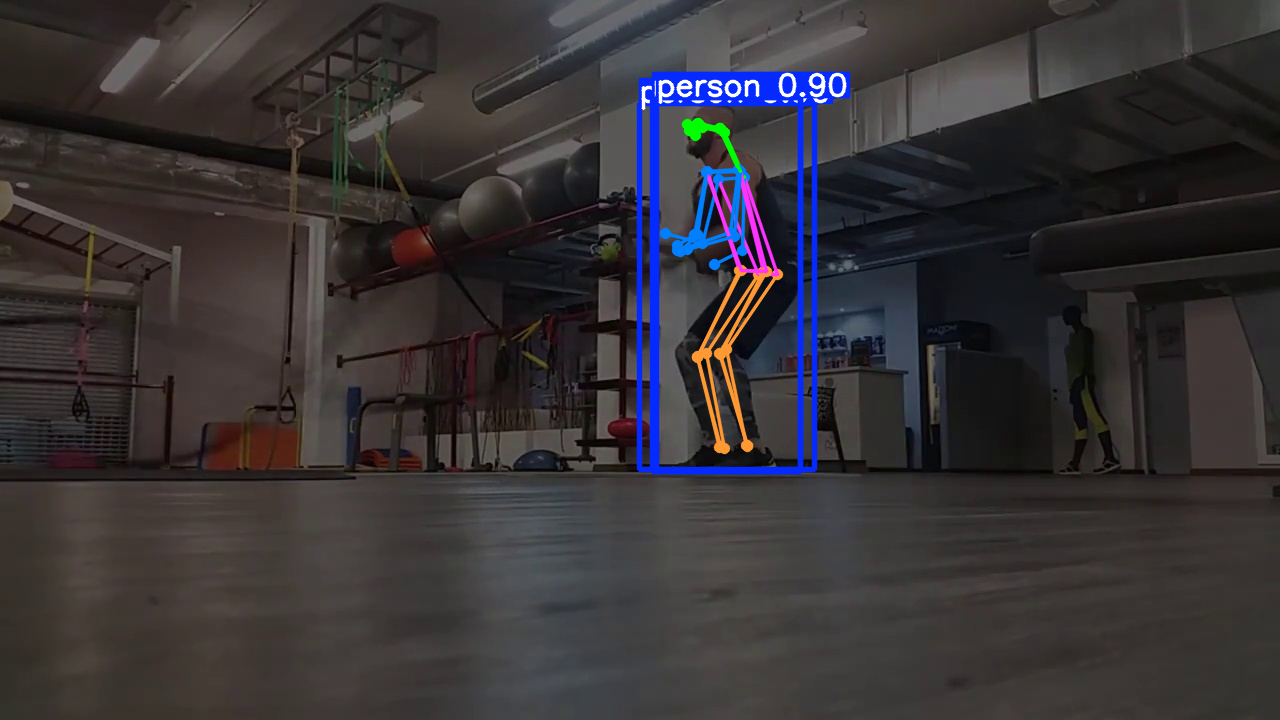

In [35]:
# Visualize the result and get the resized image

pil_image = Image.open(frame_file.get_path())

if not frame_annotations[0][2].is_detected:
    im_rgb = pil_image
else: 
    # Convert RGB to BGR
    rgb_array = np.asarray(pil_image)
    
    if rgb_array.ndim == 3 and rgb_array.shape[2] == 3:
        bgr_array = rgb_array[:, :, ::-1]
    else:
        # If the image is not RGB (e.g., grayscale or RGBA), return as is
        bgr_array = rgb_array
    
    r = ur.engine.results.Results(
        bgr_array,
        path=frame_file.get_path(),
        names={0: 'person'},
        boxes=boxes.data,
        keypoints=keypoints.data,
    )


visualize_ultralytics_results(r, scale=1)

## Visualize frames for a list of `video_id` 

Let's adapt this algorithm to visualize pose detections for list of `video_id` 

In [36]:
from src.ultralitics_utils import fetch_frame_ids, process_frame2results

In [37]:
def plot_results(dc, video_ids, conf=0.5, top_k=10,  cols=4, figsize=(15, 3)):
    """Plot the detection results for all videos in a subplot grid."""
    
    # Calculate total frames to plot and rows needed
    total_frames = top_k * len(video_ids)
    rows = total_frames // cols + (total_frames % cols > 0)
    
    # Create a figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], rows * figsize[1]))
    axes = axes.flatten()  # Flatten axes for easy iteration

    idx = 0  # Track subplot index
    for vid in video_ids:

        # Select Detections with confidence >= "conf" and show top_k only
        dc_pose = (
            dc
            .filter(C("frame.video_id") == vid)
            .filter(C("pose.confidence") >= conf)
            .order_by("frame.frame_id", descending=False)
            .limit(top_k)   
            .save()  # Need to apply this filter
        )

        # Extract frame IDs selected in "dc_pose"
        frame_ids = fetch_frame_ids(dc_pose)

        # Show all Detections for each selected frames
        for fid in frame_ids:
            
            if idx >= axes.size:
                print(f"Reached subplot limit. Skipping further frames for video {vid}.")
                break

            # Fetch frame annotations and frame image file
            frame_annotations = list(dc_pose.filter(C("frame.frame_id") == fid).collect("file", "frame", "pose"))
            img_file = frame_annotations[0][0]
            pose_detections = [annotation[2] for annotation in frame_annotations]
        
            # Convert Detections into Ultralitics' Results object and get annotated image
            r = process_frame2results(img_file, pose_detections)
            im_rgb = visualize_ultralytics_results(r, scale=1)

            # Plot image in the corresponding subplot
            ax = axes[idx]
            ax.imshow(im_rgb)
            ax.axis('off')  # Hide axes
            ax.set_title(f"{'/'.join(img_file.get_path().split('/')[-2:])}")

            idx += 1  # Move to the next subplot

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


['18b1e7df04449571abe12fadde2004f2321847ebcb18f5250a80bfb0e30363', '315be2e1145ac848e367f9d38aa6592b242b2e9a843502b3b827743462c236', '4c9c90aedeb674b8452ec2f788b5d0ba13b776c35bdf1544ac0a7e1ee3bb75', '4e7272065b591f9e07f9fa819ef290aee797e373630d008bc5f9448e173628', '52f6f41a4ae07024a5e16f58b1cc4fab75f4bddccee1d43f721abfe135edd2', '893cdf45399a0d029d2b7d53119b5e0360a877908cbbe86aaa60fbfc830d17', '9Ohpl6l4gEI', 'ADtYZmfgeSM', 'AIF4DmpgrtI', 'ANwVUvD712A', 'AUg1Thvho14', 'AYF9WardS9M', 'AeQvqXzXZCM', 'AeWHzF-65k4', 'AtEODzq0S6A', 'Auf6zunrY5s', 'b87b0636d9422f36974da34e6edcb96d5381ba8e9874c8b7b370f9853d9a0a', 'bb24cf1d342af944c22898dfbf8b861bd06a6f0f4b0e255fff14a5ff0406f6', 'c79dcbe1dd8f831ddf31d404aef8d40bafabcafffb06469575b89e702eb896', 'c932d4e24615d94c2a8dc4eb9cd83c6cf6be5bad320802a58e4fddbb69ead3']


Saving: 10 rows [00:00, 2186.36 rows/s]
Saving: 10 rows [00:00, 2585.72 rows/s]
Saving: 10 rows [00:00, 2590.84 rows/s]


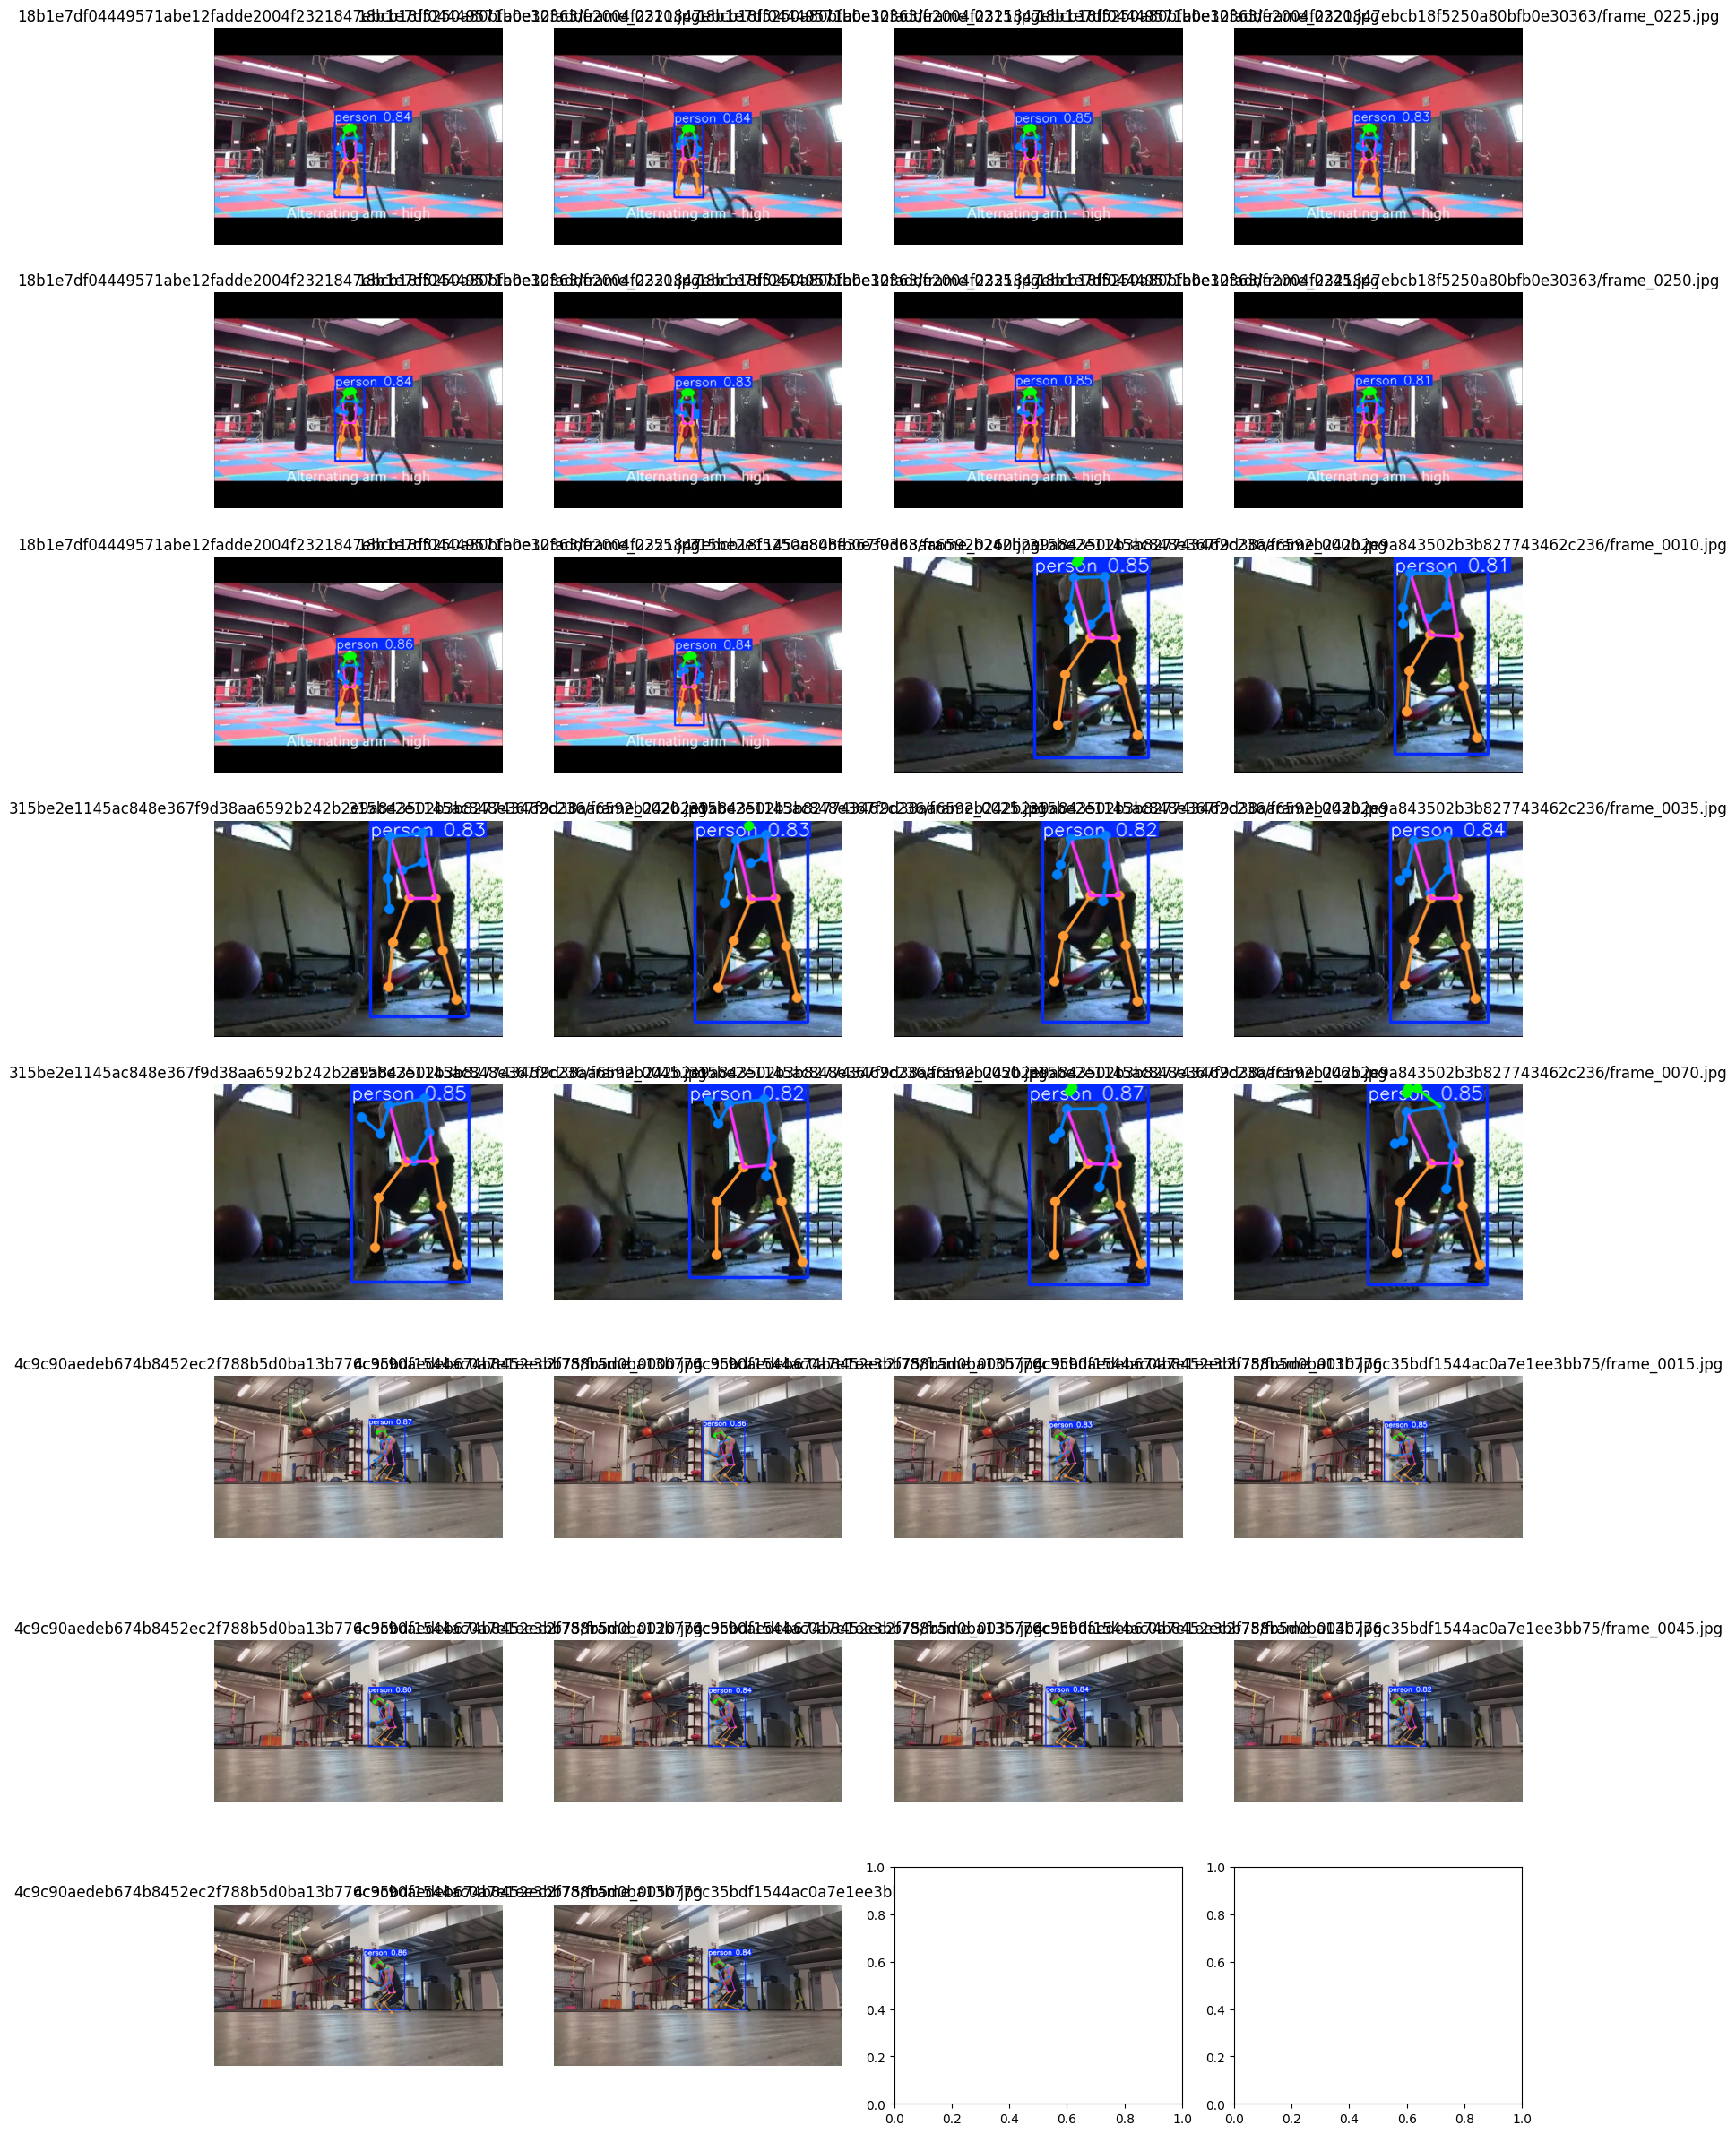

In [38]:
# Example usage
dc_pose = DataChain.from_dataset('k700-top-frames-pose')

video_ids = list(dc_pose.filter(C("pose.confidence") > 0.8).distinct("frame.video_id").collect("frame.video_id"))
print(video_ids)

plot_results(dc_pose, video_ids[:3], top_k=10,  conf=0.8, cols=4, figsize=(15, 3))

# 🎉 Summary 

👏 **Congratulations on completing this tutorial!** 

We are happy to hear about your insights and use case. Please, don't hesitate to share your thoughts and feature requests! 

How to update this into your project? 
1. Design DataModel classes for metadata and annotations
2. Create DataChains for media files and annotations (from cloud buckets, folders, json, csv, etc.)
3. Merge media and annotation DataChains for easy processing and filtering
4. Add utils and visualizations for DataChains.

🤝 **Get Involved**

We'd love to have you join our growing community of DataChain users and contributors! Here's how you can get involved:

- ⭐ Give us a star on [GitHub](https://github.com/iterative/datachain) to show your support
- 🌐 Visit the [datachain.ai website](https://datachain.ai/) to learn more about our products and services
- 📞 Contact us to discuss on scaling 🚀 DataChain for your project!
- 🙌 Follow us on [LinkedIn](https://www.linkedin.com/company/dvc-ai/) and [Twitter](https://x.com/DVCorg) for the latest updates and insights

Thanks for choosing DataChain, and happy coding! 😄